<a href="https://colab.research.google.com/github/ddfulaa/Machine-Learning-Notes/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 2 - Machine Learning**
### Student: Daniel Dario Fula Arguello - ddfulaa@unal.edu.co
### Student: Carlos Ernesto Isaza Carvajal - ceisazac@unal.edu.co
### Student: Hendrik Eugenio Olaya Castro - heolayac@unal.edu.co

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Word Language Detector
Train an SVM for detecting whether a word belongs to English or Spanish.



### (1a) Training and test data sets building
Build training and test data sets. You can use the most frequent words in http://en.wiktionary.org/wiki/Wiktionary:Frequency_lists. Consider words at least 4
characters long and ignore accents.

In [ ]:
!pip install wordfreq
import wordfreq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
def contains_non_english_alphabet(string):
    """Check if a string contains non-English alphabet characters.
    Args:
        string (str): The string to check.
    Returns:
        bool: True if the string contains non-English alphabet characters, False otherwise.
    """
    pattern = re.compile(r'[^a-zA-Z]')
    return pattern.search(string) is not None


def make_dataset(es_dict,en_dict,limit_words=1000):
  """Create a Pandas DataFrame containing information about words in two dictionaries.
    Args:
        es_dict (dict): A dictionary containing Spanish words as keys and their
            frequencies as values.
        en_dict (dict): A dictionary containing English words as keys and their
            frequencies as values.
        limit_words (int, optional): The maximum number of words to include in
            the DataFrame. Defaults to 1000.
    Returns:
        pandas.DataFrame: A DataFrame containing information about the words
            in the two dictionaries that meet certain conditions.
    """
  words={'word':[],'language':[],'frequency':[]}

  common_words=set(wordfreq.top_n_list('en', 200000)).intersection(set(wordfreq.top_n_list('es', 200000)))

  # Iterate over the Spanish dictionary and add information about each word
  # to the word dictionary if it meets certain conditions.
  for word,freq in es_dict.items():
    if len(word)>=4 and not contains_non_english_alphabet(word) and len(words['word'])<=limit_words/2 and word not in common_words:
      words['word'].append(word)
      words['language'].append(-1)
      words['frequency'].append(freq)

  # Iterate over the English dictionary and add information about each word
  # to the word dictionary if it meets certain conditions.
  for word,freq in en_dict.items():
    if len(word)>=4 and not contains_non_english_alphabet(word)and len(words['word'])<=limit_words and word not in common_words:
      if (word not in es_dict) or (en_dict[word]>es_dict[word]): 
        words['word'].append(word)
        words['language'].append(1)
        words['frequency'].append(freq)

  return pd.DataFrame(words)
# Get frequency dictionaries for English and Spanish words.
es_dict = wordfreq.get_frequency_dict('es', wordlist='best')
# Create a DataFrame containing information about the words in the two
# dictionaries that meet certain conditions (ength >= 4 characters, contain only English alphabet characters, 
#length of words must be less than or equal to limit_words, if the word is present in both dictionaries it is not added to the DataFrame)
en_dict = wordfreq.get_frequency_dict('en', wordlist='best')
words_df=make_dataset(es_dict,en_dict,limit_words=2000)

*Observation*: The dataset was created by filtering the list of most frequent words in each language to include only those with more than 4 characters and no special characters. If the same word appeared in both languages, it was classified based on its frequency.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid, _ , _ = train_test_split(words_df, words_df, test_size=0.33, random_state=42)

X = words_df.copy().drop(['frequency','language'],axis=1)
y = words_df.copy().pop('language')

X_train, X_valid,y_train,y_valid= train_test_split(X, y, test_size=0.33, random_state=42)

### (1b) Histogram cosine kernel implementation
Implement different string kernels:

i) Histogram cosine kernel: calculate a bag of n-grams representation (use the `CountVectorizer` from  scikit-learn) and apply the `cosine_similarity` from scikit-learn.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def histogram_cosine_kernel(X, Y=None, ngram_range=(1,4),debug=False):
  """
    Computes the cosine similarity between the histograms of n-grams of X and Y.    
    Args:

    X: a list of strings representing words
    Y: a list of strings representing words. If None, the function will compute the self-similarity of X.
    ngram_range: a tuple specifying the range of n-grams to be extracted from the text
    debug: a boolean value indicating whether to print debugging information, default ngram_range=(1,4)
       
    Returns:
    A numpy array containing the pairwise cosine similarities between the documents in X and X or X and Y.
  """
  
  vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer='char')
  if Y==None:
    freq_of_ngrams = vectorizer.fit_transform(X)
    if debug:
      print(f'Bag of n-grams:\n{vectorizer.get_feature_names_out()}')
      print(f'Frecuency of ngrams:\n{freq_of_ngrams.toarray()}') 
      #print(f'Bag of ngrams:\n{vectorizer.vocabulary_}') 

    return cosine_similarity(freq_of_ngrams)
  else:
    freq_of_ngrams = vectorizer.fit_transform(X+Y)
    if debug:
      print(f'Bag of n-grams:\n{vectorizer.get_feature_names_out()}')
      print(f'Frecuency of ngrams:\n{freq_of_ngrams.toarray()}') 
    return cosine_similarity(freq_of_ngrams[:len(X)],freq_of_ngrams[len(X):])

### (1b) Histogram intersection kernel implementation
ii. Histogram intersection: calculate a bag of n-grams representation, normalize it (the
sum of the bins must be equal to 1 $∀i, ||x_i
||_1 = 1$.) and calculate the sum of the
minimum for each bin of the histogram.

In [ ]:
import numba as nb
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

@nb.njit(fastmath=True, parallel=True)
def histogram_intersection_kernel_matrix(X_norm):
  """Compute the Histogram Intersection Kernel Matrix for a given matrix X_norm.
    
    Args:
    X_norm: The normalized input matrix.
    
    Returns:
    The Histogram Intersection Kernel Matrix for the input matrix.
  """
  i_samples = X_norm.shape[0]
  k = np.zeros((i_samples, i_samples), dtype=np.float64)
  for i in nb.prange(i_samples):
    for j in range(i,i_samples):
      sim = np.sum(np.minimum(X_norm[i], X_norm[j]))
      if sim > 0:
        k[i, j] = sim
        k[j, i] = sim
  return k

@nb.njit(fastmath=True, parallel=True)
def histogram_intersection_kernel_matrix_XY(X_norm,Y_norm):
  """Compute the Histogram Intersection Kernel Matrix for two given matrices X_norm and Y_norm.
    
    Args:
    X_norm: The first normalized input matrix.
    Y_norm: The second normalized input matrix.
    
    Returns:
    The Histogram Intersection Kernel Matrix for the input matrices.
  """
  i_samples = X_norm.shape[0]
  j_samples = Y_norm.shape[0] 
  k = np.zeros((i_samples, j_samples), dtype=np.float64)
  for i in nb.prange(i_samples):
    for j in nb.prange(j_samples):
      sim = np.sum(np.minimum(X_norm[i], Y_norm[j]))
      if sim > 0:
        k[i, j] = sim
  return k
  

In [ ]:
def get_normalized_freq(words, ngram_range=(1,4)):
    """Return normalized frequency of ngrams in words.

    Parameters:
    words (list): A list of strings.
    ngram_range (tuple): A tuple of integers representing the minimum and maximum size of ngrams.

    Returns:
    numpy.ndarray: A normalized frequency matrix of ngrams in words.
    """
    # Create a vectorizer to extract ngrams from the words.
    vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer='char')
    # Extract ngrams and compute their frequencies.
    freq_of_ngrams = vectorizer.fit_transform(words)
    # Normalize the frequency matrix along the rows.
    return normalize(freq_of_ngrams, norm='l1', axis=1)

def histogram_intersection_kernel(X,Y=None, ngram_range=(1,4)):
  """Compute the histogram intersection kernel between X and Y.

    Parameters:
    X (list): A list of strings representing the first set of documents.
    Y (list): A list of strings representing the second set of documents.
    ngram_range (tuple): A tuple of integers representing the minimum and maximum size of ngrams.

    Returns:
    numpy.ndarray: A kernel matrix of shape (m,n), where m is the number of documents in X and n is the number of documents in Y.
  """
  if Y==None:
    X_norm=get_normalized_freq(X).toarray()
    k=histogram_intersection_kernel_matrix(X_norm)
  else:
    aux=get_normalized_freq(X+Y)
    X_norm=aux[:len(X)]
    Y_norm=aux[len(X):]
    k=histogram_intersection_kernel_matrix_XY(X_norm.toarray(),Y_norm.toarray())
  return k

### (1b) $\chi^2$ kernel implementation
iii. $\chi^2$ kernel: calculate a bag of n-grams representation and apply the `chi2_kernel` from scikit-learn.

In [ ]:
from sklearn.metrics.pairwise import chi2_kernel as chidos

def chi2_kernel(X, Y=None, ngram_range=(1,4)):
  """Compute the chi-squared kernel between each pair of samples in X and Y.

  Args:
    X (list or array-like): A collection of strings.
    Y (list or array-like): A collection of strings (optional).
    ngram_range (tuple): Range for n-gram extraction (default: (1,4)).

  Returns:
    A matrix with shape (len(X), len(Y)) containing the pairwise chi-squared
    kernel values between each sample in X and Y.
  """
  vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer='char')
  # Compute chi-squared kernel for X only
  if Y==None:
    freq_of_ngrams = vectorizer.fit_transform(X)
    return chidos(freq_of_ngrams.toarray())
  # Compute chi-squared kernel for X and Y
  else:
    freq_of_ngrams = vectorizer.fit_transform(X+Y)
    return chidos(freq_of_ngrams[:len(X)].toarray(),freq_of_ngrams[len(X):].toarray())
  

### (1b) SSK kernel implementation
iv. SSK kernel: use the code available at this repository https://github.com/helq/python-ssk .

In [ ]:
%load_ext Cython

In [ ]:
%%cython
import numpy as np
cimport numpy as np

from cpython cimport array
import array

cimport cython

def ssk(s, t, int n, float lbda, accum=False):
    """Compute the SSK kernel similarity between two strings s and t.

    Parameters:
    s (str or list of chars): the first string
    t (str or list of chars): the second string
    n (int): maximum length of subsequences to be considered
    lbda (float): decay factor used to penalize gaps between characters in a subsequence
    accum (bool): whether to accumulate or not

    Returns:
    float: the similarity between s and t computed by the SSK kernel
    """
    s_array = array.array('l', [ord(c) for c in s])
    t_array = array.array('l', [ord(c) for c in t])
    return ssk_array(s_array, t_array, n, lbda, accum)

# Kernel defined by Lodhi et al. (2002)
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def ssk_array(array.array s_, array.array t_, int n, float lbda, accum=False):
    """Compute the SSK kernel similarity between two strings represented as arrays of ints.

    Parameters:
    s_ (array.array of ints): the first string as an array of ints
    t_ (array.array of ints): the second string as an array of ints
    n (int): maximum length of subsequences to be considered
    lbda (float): decay factor used to penalize gaps between characters in a subsequence
    accum (bool): whether to accumulate or not

    Returns:
    float: the similarity between s_ and t_ computed by the SSK kernel
    """
    cdef int lens, lent
    cdef int i, sj, tk
    cdef float toret
    cdef long[:] s # this reduces the overhead 10x fold!!!
    cdef long[:] t

    s = s_ if s_.typecode == 'l' else array.array('l', [int(c) for c in s_])
    t = t_ if t_.typecode == 'l' else array.array('l', [int(c) for c in t_])

    lens, lent = len(s), len(t)
    #k_prim = (-1)*np.ones( (n+1, lens, lent) )
    cdef np.ndarray[np.float64_t, ndim=3] \
        k_prim = np.zeros((n, lens, lent), dtype=float)

    k_prim[0,:,:] = 1

    for i in range(1,n):
        for sj in range(i,lens):
            toret = 0.
            for tk in range(i,lent):
                if s[sj-1]==t[tk-1]: # trick taken from shogun implemantion of SSK
                    toret = lbda * (toret + lbda*k_prim[i-1,sj-1,tk-1])
                else:
                    toret *= lbda
                k_prim[i,sj,tk] = toret + lbda * k_prim[i, sj-1, tk]

    cdef int start = 0 if accum else n-1
    cdef float k = 0.

    for i in range(n):
        for sj in range(i,lens):
            for tk in range(i,lent):
                if s[sj]==t[tk]:
                    k += lbda*lbda*k_prim[i,sj,tk]

    # print( [len(list(i for (sj,tk,i) in k_prim if i==m-1)) for m in range(n)] )
    return k

def string_kernel(xs, ys, n, lbda):
    """
    Calculates the string kernel matrix between two arrays of strings or arrays of ints.

    Args:
    xs: np.ndarray, shape (m, 1), type str or array.array
        First array of strings or arrays of ints
    ys: np.ndarray, shape (n, 1), type str or array.array
        Second array of strings or arrays of ints
    n: int
        Maximum length of substrings to match
    lbda: bool
        If True, uses the lambda parameter to adjust the importance of long substrings.

    Returns:
    np.ndarray, shape (m, n), type float64
        The string kernel matrix normalized with the square root of the diagonal.

    Raises:
    ValueError: If the shape of the input arrays is not correct.

    """
    if len(xs.shape) != 2 or len(ys.shape) != 2 or xs.shape[1] != 1 or ys.shape[1] != 1:
        raise "The shape of the features is wrong, it must be (n,1)"

    cdef int lenxs, lenys
    cdef int i, j
    cdef np.ndarray[np.float64_t, ndim=2] mat, mat_xs, mat_ys
    lenxs, lenys = xs.shape[0], ys.shape[0]

    mat = np.zeros((lenxs, lenys))

    ssk_fun = ssk_array if xs.dtype == 'O' and isinstance(xs[0,0], array.array) else ssk

    # If both lists are equal, then the resulting matrix is symetric, there is no need to
    # calculate the hole thing
    if lenxs == lenys and np.array_equal(xs, ys):
        for i in range(lenxs):
            for j in range(i,lenys):
                mat[j,i] = mat[i,j] = ssk_fun(xs[i,0], ys[j,0], n, lbda, accum=True)

        mat_xs = mat_ys = mat.diagonal().reshape((lenxs, 1))

    else:
        for i in range(lenxs):
            for j in range(lenys):
                mat[i,j] = ssk_fun(xs[i,0], ys[j,0], n, lbda, accum=True)

        mat_xs = np.zeros((lenxs, 1))
        mat_ys = np.zeros((lenys, 1))

        for i in range(lenxs):
            mat_xs[i] = ssk_fun(xs[i,0], xs[i,0], n, lbda, accum=True)
        for j in range(lenys):
            mat_ys[j] = ssk_fun(ys[j,0], ys[j,0], n, lbda, accum=True)

    return np.divide(mat, np.sqrt(mat_ys.T * mat_xs))


In [ ]:
def get_ssk_kernel_for_scikit(max_substring=4, lambda_decay=0.8):
    """
    Returns a string kernel function that can be used with scikit-learn estimators.
    
    Args:
        max_substring (int, optional): The maximum length of substrings to consider. Defaults to 4.
        lambda_decay (float, optional): The decay factor to apply to longer substrings. Defaults to 0.8.
    
    Returns:
        function: A string kernel function that takes two inputs and returns their similarity score.
    """
    def strker(iX, iY=None, max_substring=max_substring, lambda_decay=lambda_decay):
      """
      A helper function that computes the string kernel for two input arrays.
        
        Args:
            iX (numpy.ndarray): The first input array.
            iY (numpy.ndarray, optional): The second input array. Defaults to None.
            max_substring (int, optional): The maximum length of substrings to consider. Defaults to the value set in get_ssk_kernel_for_scikit.
            lambda_decay (float, optional): The decay factor to apply to longer substrings. Defaults to the value set in get_ssk_kernel_for_scikit.
        
        Returns:
            numpy.ndarray: The similarity score for the two input arrays.
        """
      X = np.array(iX).reshape((len(iX), 1))
      if iY==None:
        return string_kernel(X, X, max_substring, lambda_decay)
      else:
        Y = np.array(iY).reshape((len(iY), 1))
        return string_kernel(X, Y, max_substring, lambda_decay)
    return strker

## lambda controls the contribution of each subsequence to the overall similarity score. 
## As lambda decreases, the contribution of longer subsequences is reduced. 
## This is useful when we want to focus on the similarity of shorter subsequences rather than longer ones. 
## The parameter n controls the maximum length of subsequences to consider, as you mentioned earlier.
my_ssk = get_ssk_kernel_for_scikit(4, 0.8)

### (1c) Training
c) Use scikit-learn to train different SVMs using precomputed kernels. Use cross validation to find appropriate regularization parameters plotting the training and validation error vs. the regularization parameter. Use a logarithmic scale for $C$, $\{2^{-15},2^{-14},\cdots, 2^{10}\}$.
Try different configurations of the parameters (in particular different $n$ values for the n-grams).

To start, let's calculate the kernel matrices for all kernels to be tested, and the `X_valid` matrices too.

In [ ]:
def make_kernel_matrices(max_n_grams, X_train, X_valid):
  """
    This function creates a dictionary with several kernel matrices based on different
    kernel functions and n-gram ranges.

    Parameters:
    max_n_grams (int): Maximum number of n-grams to consider.
    X_train (list): List of training data.
    X_valid (list): List of validation data.

    Returns:
    kernel_matrices (dict): A dictionary containing all kernel matrices.

  """
  kernel_matrices=dict()
  for i in range(1,max_n_grams+1):
    # Histogram-based Cosine Kernel (HCK)
    K_hck_train = histogram_cosine_kernel(list(np.array(X_train).ravel()),
                                          ngram_range=(1,i))
    K_hck_valid = histogram_cosine_kernel(list(np.array(X_valid).ravel()),
                                      list(np.array(X_train).ravel()),
                                      ngram_range=(1,i))
    # Histogram Intersection Kernel (HIK)  
    K_hik_train = histogram_intersection_kernel(list(np.array(X_train).ravel()),
                                                ngram_range=(1,i))
    K_hik_valid = histogram_intersection_kernel(list(np.array(X_valid).ravel()),
                                            list(np.array(X_train).ravel()),
                                            ngram_range=(1,i))
    # Chi-Squared Kernel (C2K)
    K_c2k_train = chi2_kernel(list(np.array(X_train).ravel()),
                              ngram_range=(1,i))
    K_c2k_valid = chi2_kernel(list(np.array(X_valid).ravel()),
                              list(np.array(X_train).ravel()), 
                              ngram_range=(1,i))
    # String Subsequence Kernel (SSK)
    K_ssk_train = my_ssk(list(np.array(X_train).ravel()),
                         max_substring=i,
                         lambda_decay=1)
    K_ssk_valid = my_ssk(list(np.array(X_valid).ravel()),
                         list(np.array(X_train).ravel()),
                         max_substring=i,
                         lambda_decay=1)
    # SSK with lambda_decay=0.8
    K_ssk8_train = my_ssk(list(np.array(X_train).ravel()),
                         max_substring=i,
                         lambda_decay=0.8)
    K_ssk8_valid = my_ssk(list(np.array(X_valid).ravel()),
                          list(np.array(X_train).ravel()),
                          max_substring=i,
                          lambda_decay=0.8)
    # SSK with lambda_decay=0.5
    K_ssk5_train = my_ssk(list(np.array(X_train).ravel()),
                         max_substring=i,
                         lambda_decay=0.5)
    K_ssk5_valid = my_ssk(list(np.array(X_valid).ravel()),
                          list(np.array(X_train).ravel()),
                          max_substring=i,
                          lambda_decay=0.5)
    # SSK with lambda_decay=0.2
    K_ssk2_train = my_ssk(list(np.array(X_train).ravel()),
                         max_substring=i,
                         lambda_decay=0.2)
    K_ssk2_valid = my_ssk(list(np.array(X_valid).ravel()),
                          list(np.array(X_train).ravel()),
                          max_substring=i,
                          lambda_decay=0.2)
    # Add all kernel matrices to dictionary
    kernel_matrices[str(i)+'-grams']={'hck':{'matrix':np.copy(K_hck_train),
                                             'valid':np.copy(K_hck_valid)
                                             },
                                      'hik':{'matrix':np.copy(K_hik_train),
                                             'valid':np.copy(K_hik_valid)
                                             },
                                      'c2k':{'matrix':np.copy(K_c2k_train),
                                             'valid':np.copy(K_c2k_valid)
                                             },
                                      'ssk':{'matrix':np.copy(K_ssk_train),
                                             'valid':np.copy(K_ssk_valid)
                                             },
                                      'ssk8':{'matrix':np.copy(K_ssk8_train),
                                              'valid':np.copy(K_ssk8_valid)
                                              },
                                      'ssk5':{'matrix':np.copy(K_ssk5_train),
                                              'valid':np.copy(K_ssk5_valid)
                                              },
                                      'ssk2':{'matrix':np.copy(K_ssk2_train),
                                              'valid':np.copy(K_ssk2_valid)
                                              }
                                      }

  return kernel_matrices
#kernel_matrices['2-grams']['hck']['matrix']

In [ ]:
kernel_matrices=make_kernel_matrices(5,X_train,X_valid)
#import pickle
#with open('kernel_matrices.pkl', 'wb') as file:
#    # A new file will be created
#    pickle.dump(kernel_matrices, file)
##Note: The run tooks nearly 35 minutes to complete using 4000 words as input data, and made a file of 2.8GB using pickle
##      The run tooks nearly 46 seconds to complete using 1000 words as input data, and made a file of 179MB using pickle

**Note**: To assess the errors, we will use the accuracy score as our metric since both classes are balanced and we lack information about the intended application of the classifier.

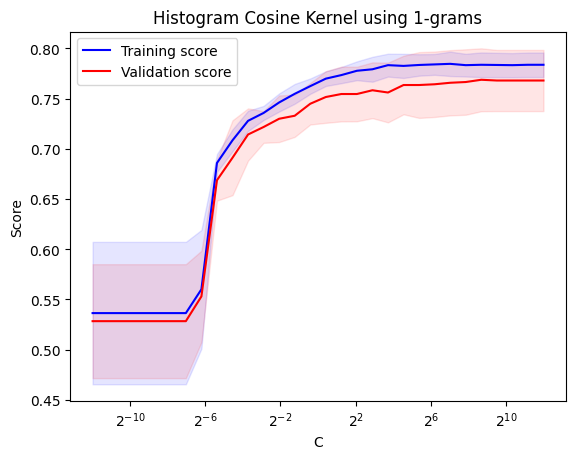

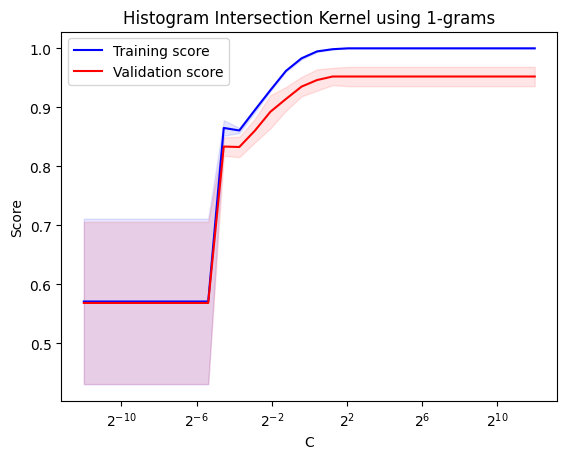

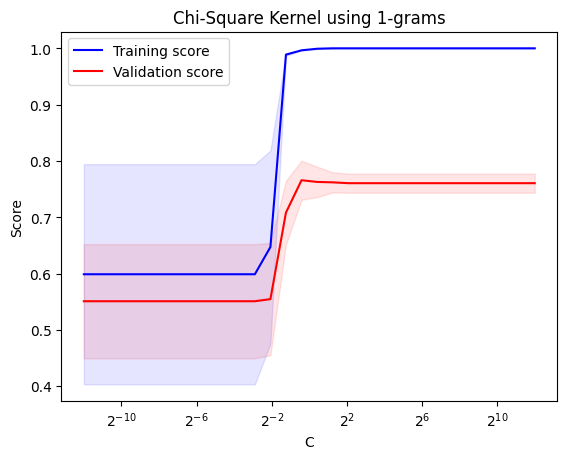

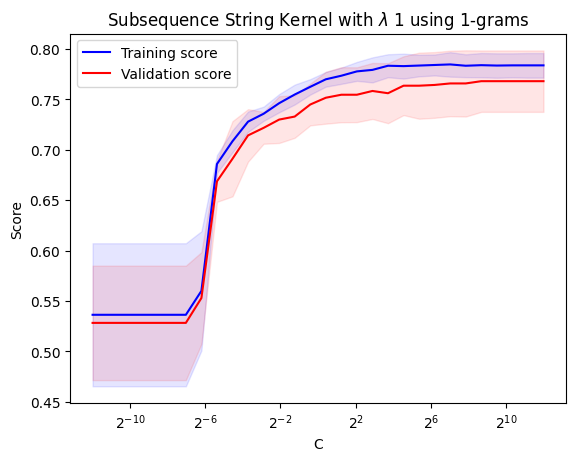

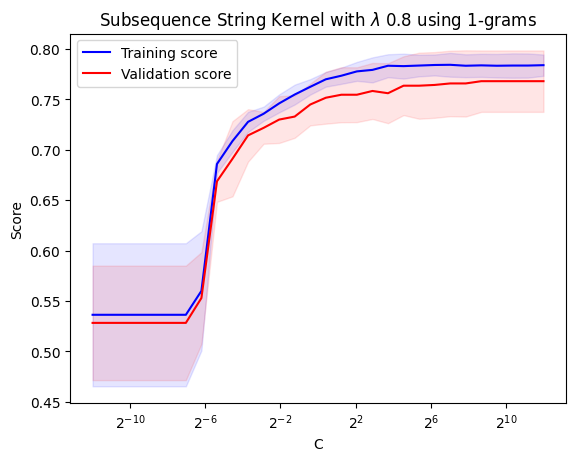

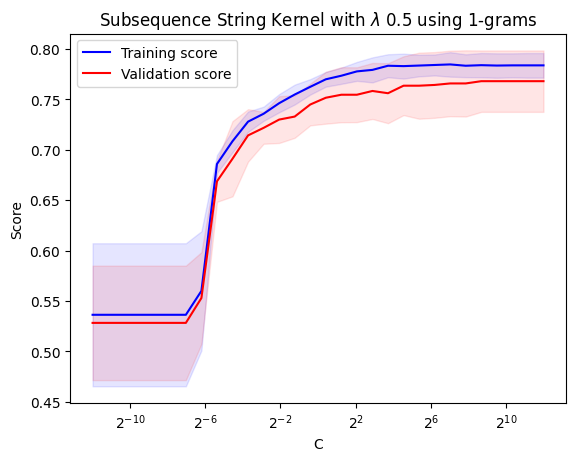

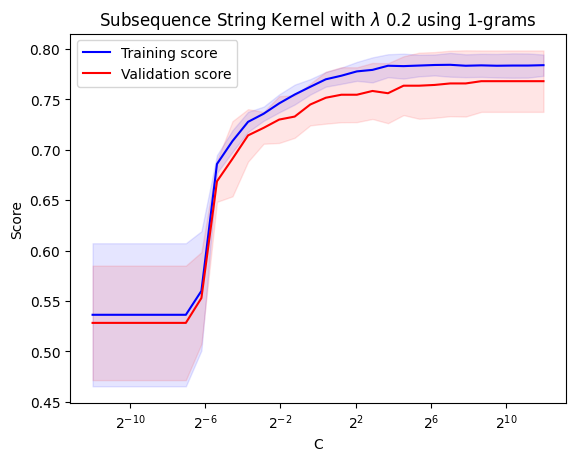

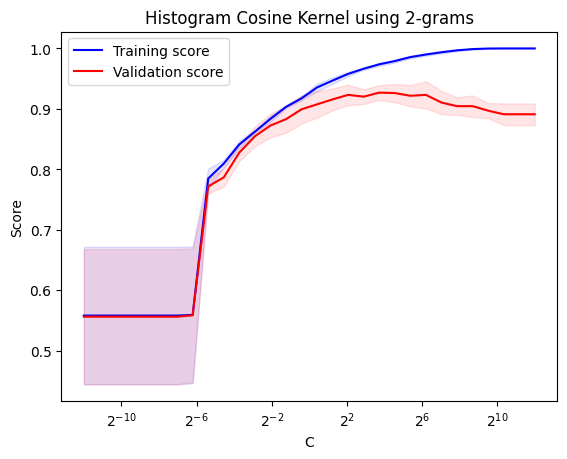

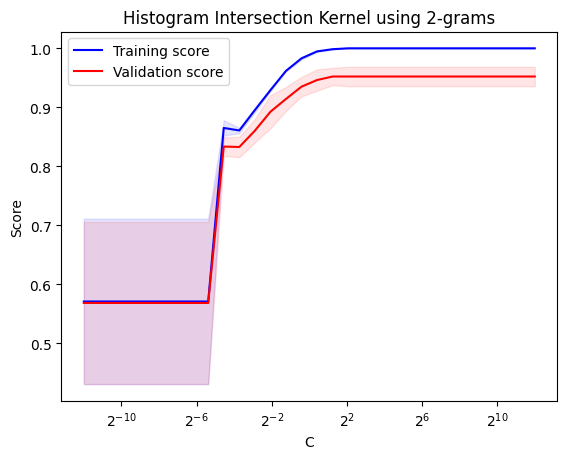

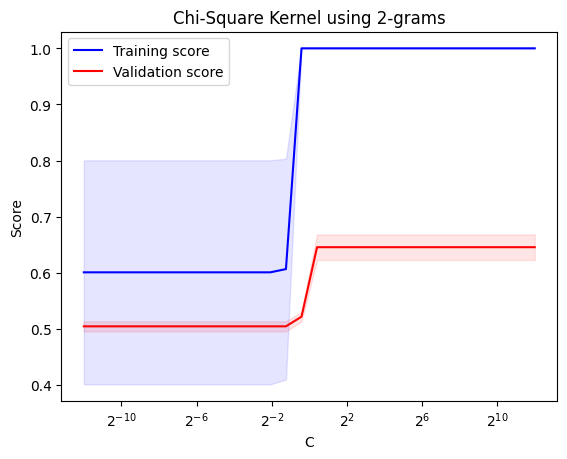

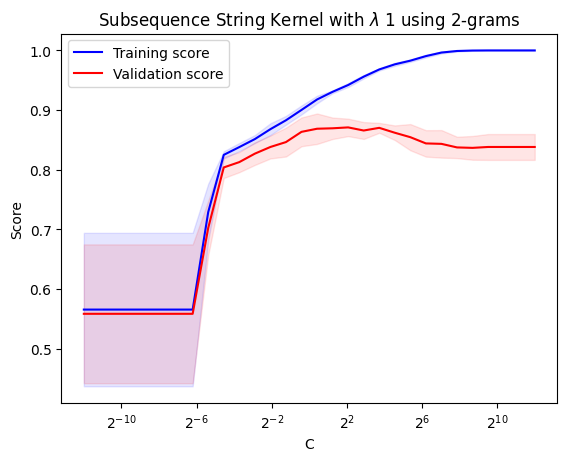

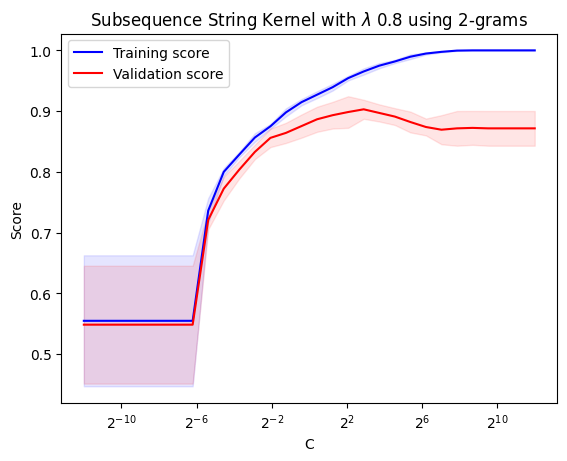

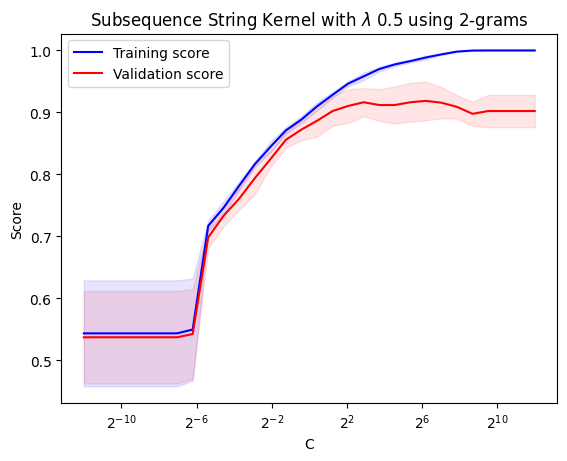

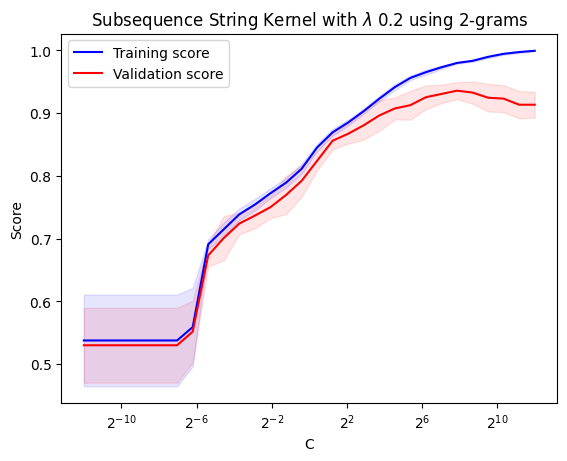

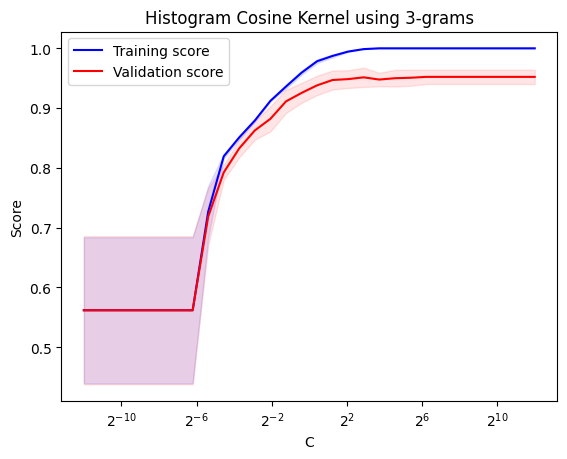

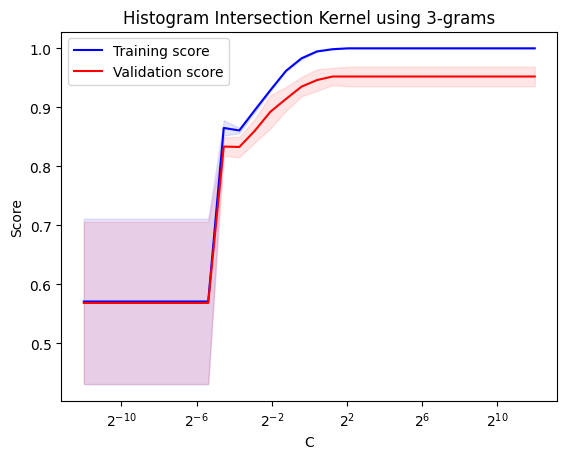

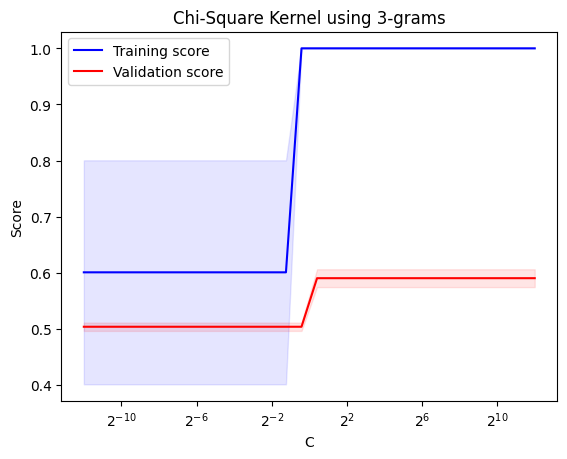

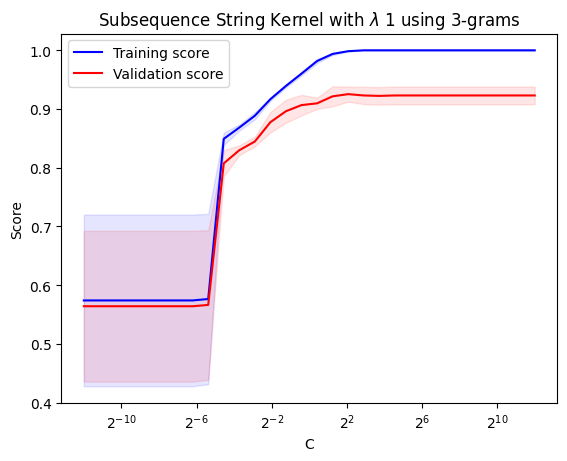

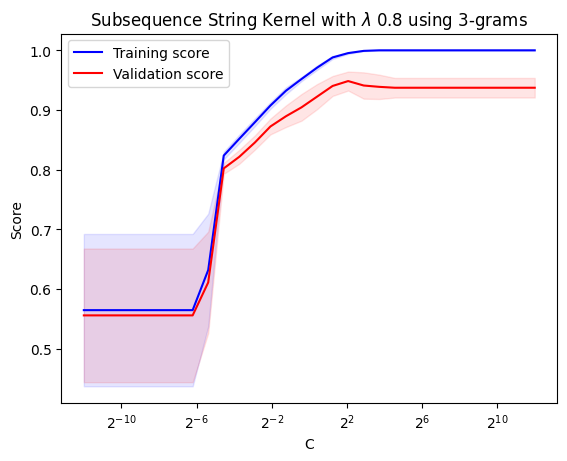

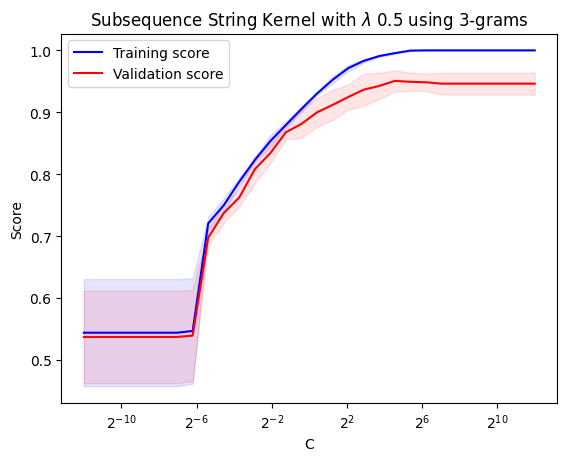

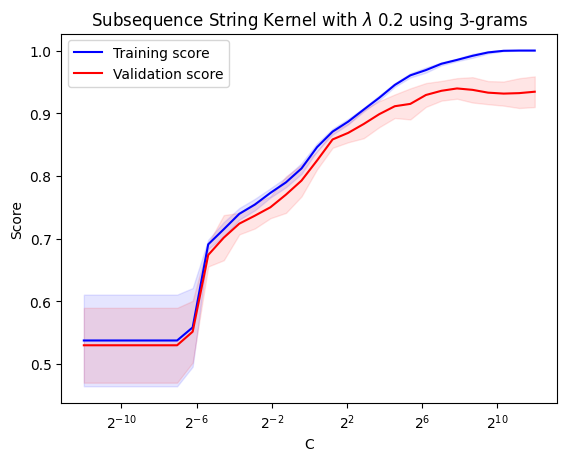

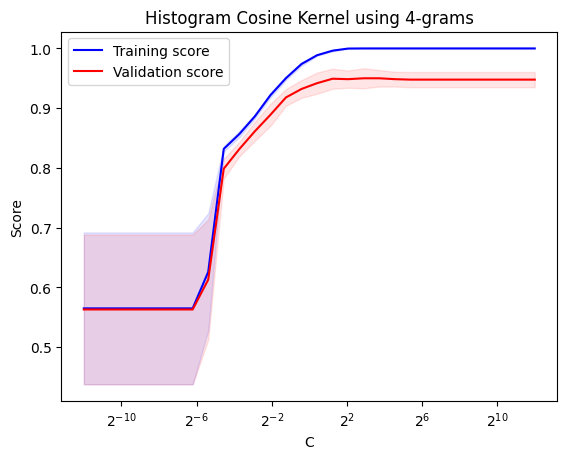

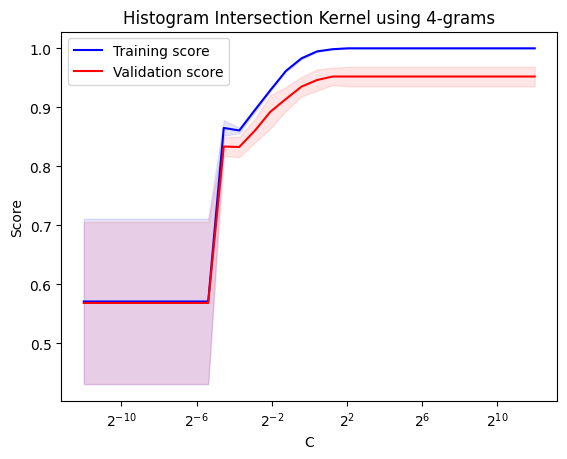

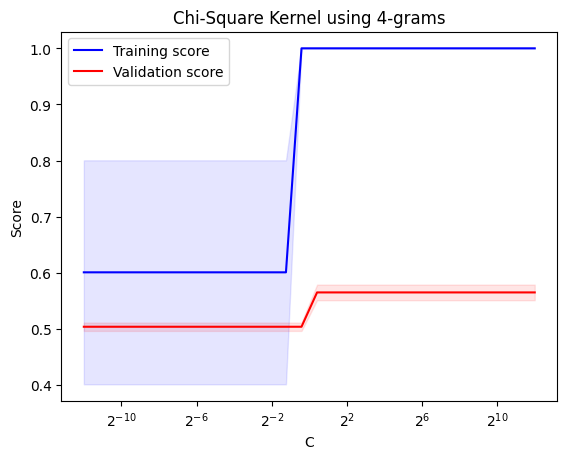

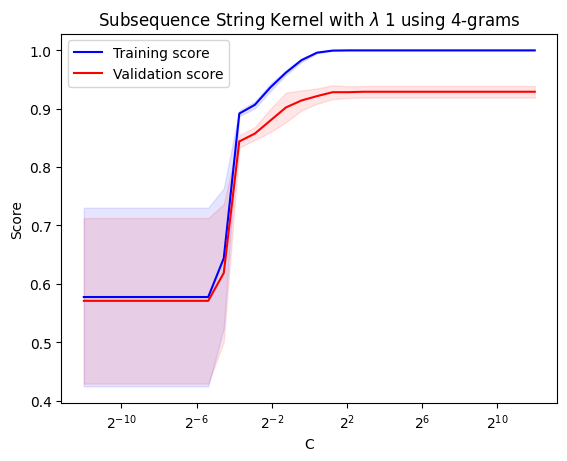

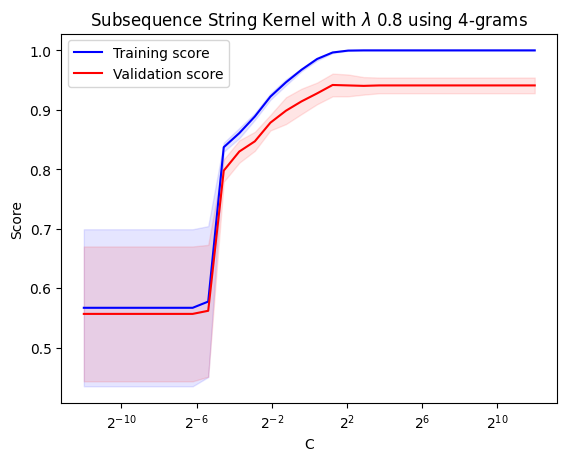

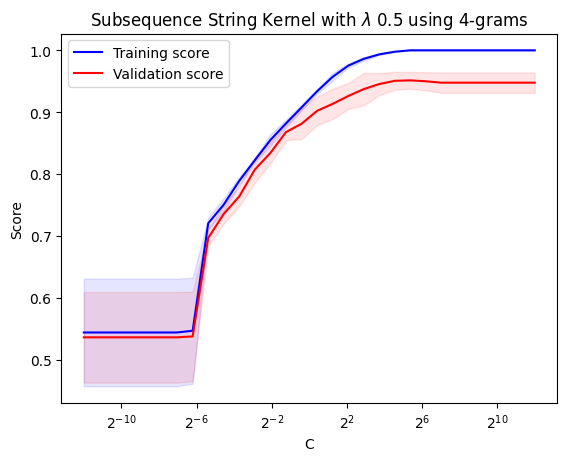

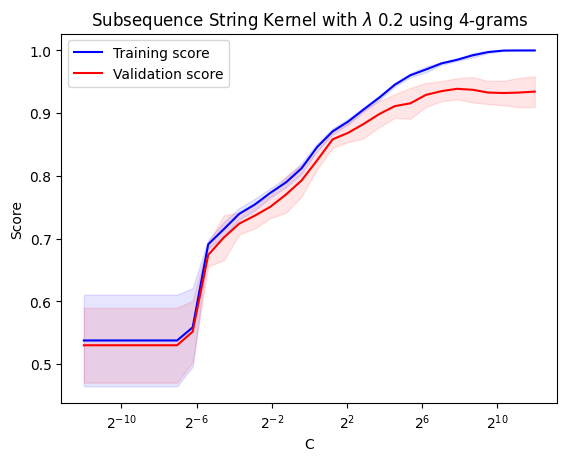

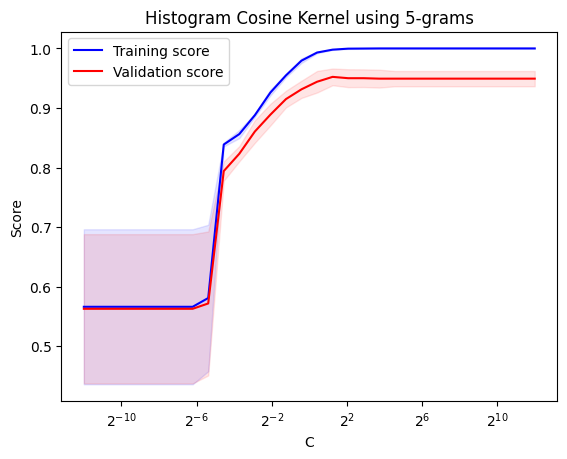

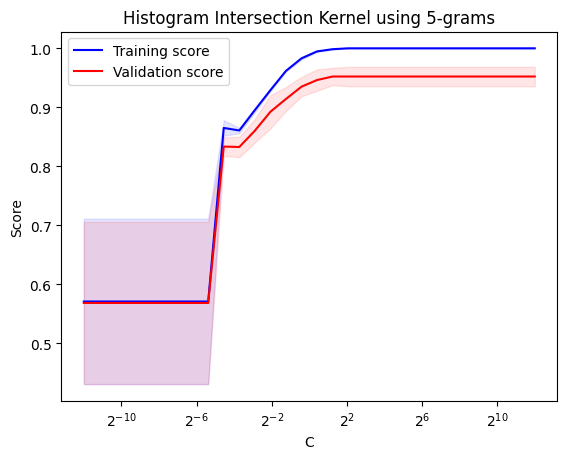

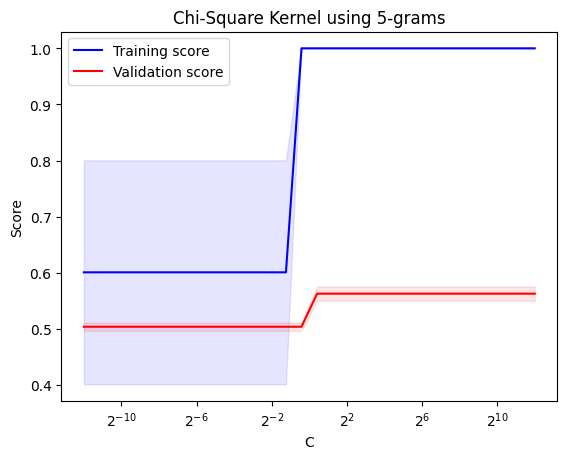

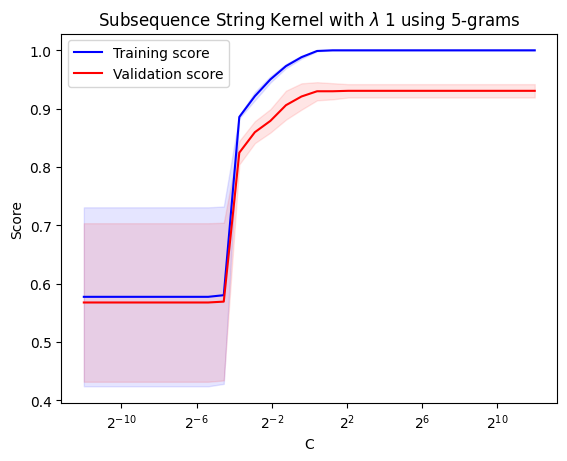

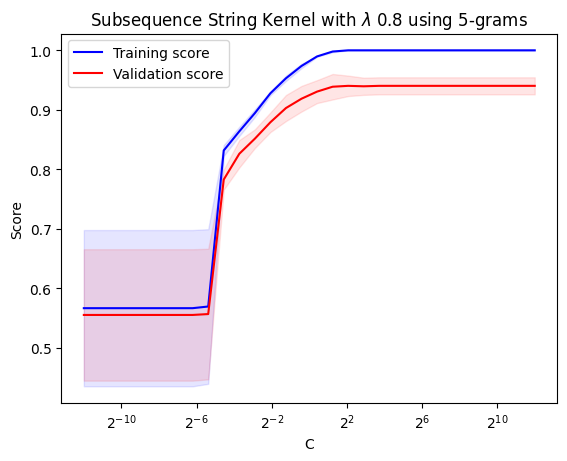

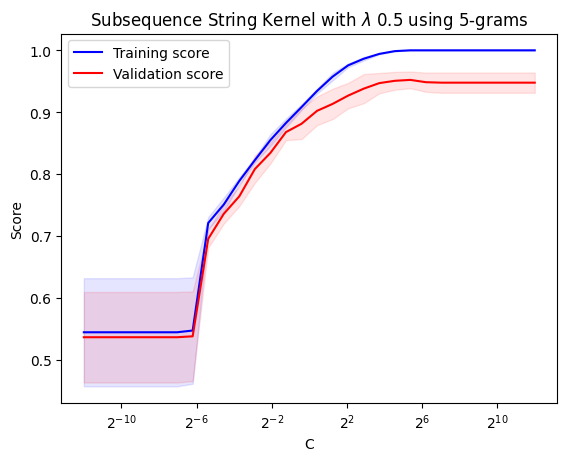

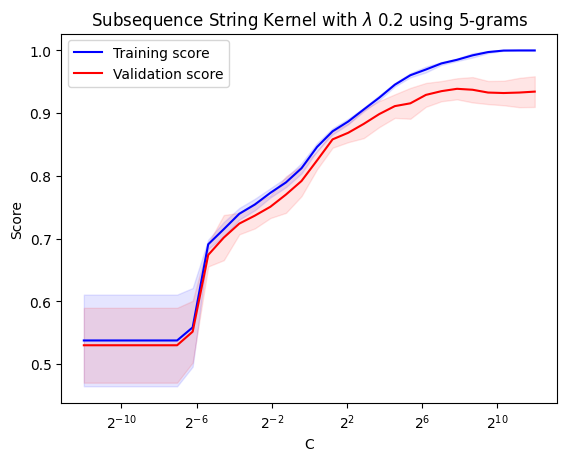

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

# Define the range of C values to explore
C_range = np.logspace(-12, 12, num=30, base=2)

# Define the parameter grid for cross-validation
param_grid = [{'C': C_range, 'kernel': ['precomputed']}]

# Define the cross-validation object
cv = 5

svc = SVC(kernel='precomputed', random_state=42)

# Perform GridSearch Using Cross Validation to find the best C for each model, we will measure using accuracy



kernel_names={'hck':'Histogram Cosine Kernel',
              'hik':'Histogram Intersection Kernel',
              'c2k':'Chi-Square Kernel',
              'ssk':'Subsequence String Kernel with $\lambda$ 1',
              'ssk8':'Subsequence String Kernel with $\lambda$ 0.8',
              'ssk5':'Subsequence String Kernel with $\lambda$ 0.5',
              'ssk2':'Subsequence String Kernel with $\lambda$ 0.2'
              }

# Find the best C and plot for each model
model_scores={'model':[],'accuracy':[]}
for n_grams, kernels in kernel_matrices.items():
  for kernel_name, kernel_info in kernels.items():
    grid_search = GridSearchCV(svc, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=False, scoring='accuracy', return_train_score=True)
    K=kernel_info['matrix'].copy()
    grid_search.fit(K, y_train)
    kernel_info['Best_C']=grid_search.best_params_['C']
    kernel_info['Best_Score']=grid_search.best_score_
    kernel_info['Best_Estimator']=grid_search.best_estimator_
    model_scores['model'].append(kernel_names[kernel_name]+'-'+n_grams)
    model_scores['accuracy'].append(grid_search.best_score_)
    # Calculate the mean and standard deviation of the training and validation scores across the folds
    train_mean = grid_search.cv_results_['mean_train_score']
    train_std = grid_search.cv_results_['std_train_score']
    valid_mean = grid_search.cv_results_['mean_test_score']
    valid_std = grid_search.cv_results_['std_test_score']

    # Plot the training and validation curves
    plt.plot(C_range, train_mean, label='Training score', color='blue')
    plt.fill_between(C_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(C_range, valid_mean, label='Validation score', color='red')
    plt.fill_between(C_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='red')
    #plt.axvline(x = grid_search.best_params_['C'], color = 'gray', linestyle = '--')
    #plt.axhline(y = grid_search.best_score_, color = 'gray', linestyle = '--')
    #plt.text(grid_search.best_params_['C'], grid_search.best_score_ - 0.1, 'Best $C$ with '+str(np.round_(grid_search.best_score_,3)), fontsize = 12)
    plt.xscale('log',base=2)
    plt.xlabel('C')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.title(kernel_names[kernel_name]+' using '+n_grams)
    plt.show()

Additionally, we could make a comparison of the classifiers' performance during training.

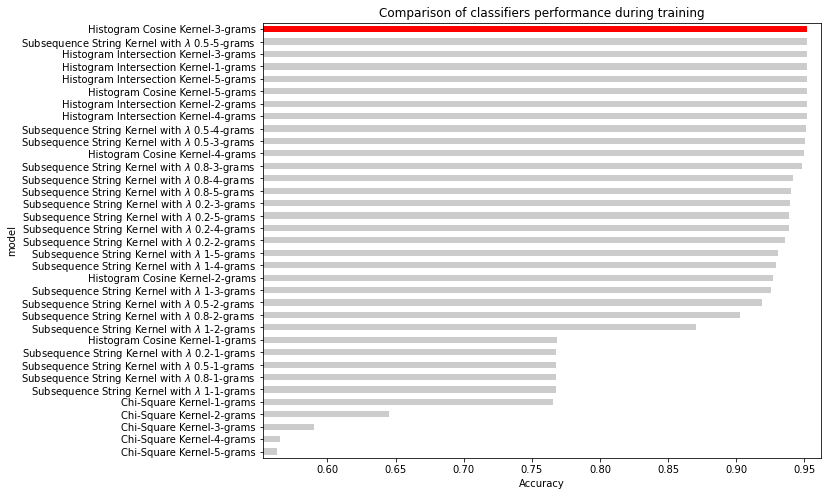

In [ ]:
aux = pd.DataFrame.from_dict(model_scores)
aux.set_index('model',inplace=True)
aux=aux['accuracy'].sort_values()
color=['0.8']*(aux.size-1)
color.append('r')
ax = aux.plot(kind='barh',
             figsize=(10,8),
               color = color)
ax.set_title('Comparison of classifiers performance during training')
ax.set_xlabel('Accuracy')
plt.xlim(aux.min()-0.01, aux.max()+0.01)
plt.show();

### (1d) Performance in Test Data
Evaluate the performance of the SVMs in the test data set:

i. Report the results in a table for the different evaluated configurations.

In this case, we will evaluate 4 most common scores for binary classification: accuracy, precision, recall, and f1 scores.

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
# Initialize dictionary to store model scores
model_pred_scores={'model':[],'accuracy':[],'precision':[],'recall':[],'f1':[]}
# Initialize dictionary to store misclassified words
misclassified_words=dict()
# Loop over all n_grams and kernels
for n_grams, kernels in kernel_matrices.items():
  for kernel_name, kernel_info in kernels.items():
    #Make the table
    y_predict=kernel_info['Best_Estimator'].predict(kernel_info['valid'])
    # Add scores to model_pred_scores dictionary
    model_pred_scores['model'].append(kernel_names[kernel_name]+'-'+n_grams)
    model_pred_scores['accuracy'].append(accuracy_score(y_valid,y_predict))
    model_pred_scores['precision'].append(precision_score(y_valid,y_predict,average='binary'))
    model_pred_scores['recall'].append(recall_score(y_valid,y_predict,average='binary'))    
    model_pred_scores['f1'].append(f1_score(y_valid,y_predict,average='binary'))
    # Add misclassified words to misclassified_words dictionary
    misclassified_words[kernel_name+'-'+n_grams]=list(np.array(X_valid[y_valid!=y_predict ]).ravel())
# Convert model_pred_scores dictionary to a pandas dataframe, sort by accuracy and f1 scores
pd.DataFrame(model_pred_scores).sort_values(by=['accuracy','f1'],ascending=False)



,model,accuracy,precision,recall,f1
1,Histogram Intersection Kernel-1-grams,0.953101,0.968553,0.936170,0.952087
8,Histogram Intersection Kernel-2-grams,0.953101,0.968553,0.936170,0.952087
15,Histogram Intersection Kernel-3-grams,0.953101,0.968553,0.936170,0.952087
22,Histogram Intersection Kernel-4-grams,0.953101,0.968553,0.936170,0.952087
29,Histogram Intersection Kernel-5-grams,0.953101,0.968553,0.936170,0.952087
26,Subsequence String Kernel with $\lambda$ 0.5-4...,0.942511,0.956113,0.927052,0.941358
28,Histogram Cosine Kernel-5-grams,0.942511,0.956113,0.927052,0.941358
19,Subsequence String Kernel with $\lambda$ 0.5-3...,0.942511,0.961905,0.920973,0.940994
21,Histogram Cosine Kernel-4-grams,0.940998,0.950311,0.930091,0.940092
33,Subsequence String Kernel with $\lambda$ 0.5-5...,0.940998,0.955975,0.924012,0.939722


#### Examples of misclassified errors and discusion
(ii) Illustrate examples of errors (English words mistaken as Spanish, Spanish words mistaken as English). Give a possible explanation for these mistakes.


In order to give a possible explanation, let's reduce our models to 4: 
* Histogram cosine kernel with 5-grams
* Subsequence String Kernel with $\lambda$ 0.5 with 4-grams
* Histogram Intersection Kernel with 5-grams
* Chi-Square Kernel with 1-grams

In [ ]:
def print_results(classifier):
  """
  Function to print results for a given classifier. 
  Inputs:
  - classifier: name of the classifier to print results for
  """
  print('***** '+classifier+' classifier')
  print('* Misclassified words are:')
  print(','.join(misclassified_words[classifier]))
  mean = np.mean([len(word) for word in misclassified_words[classifier]])
  # Compute mean and std deviation of the length of misclassified words
  std = np.std([len(word) for word in misclassified_words[classifier]])
  print(f'* The average lenght of the words misclassified is {mean}')
  print(f'* The standard deviation is {std}\n')
# Print results for each classifier
print_results('hck-5-grams')
print_results('ssk5-4-grams')
print_results('hik-5-grams')
print_results('c2k-1-grams')

***** hck-5-grams classifier
* Misclassified words are:
tercer,sirve,pursue,occur,documented,puse,candidates,applicable,disposal,enforce,remarkable,perspectiva,performs,hostile,temperatura,adjacent,touches,profitable,alrededor,compromise,anxious,inversiones,desires,unbelievable,moreover,veteran,acceptable,materiales,solicitud,actitud,uncomfortable,simplemente,quede,siglos,overcome,smallest,listas,hilarious
* The average lenght of the words misclassified is 8.31578947368421
* The standard deviation is 2.141141642821894

***** ssk5-4-grams classifier
* Misclassified words are:
sirve,occur,interference,puse,candidates,disposal,enforce,remarkable,perspectiva,performs,hostile,nearest,preference,encuentran,adjacent,comunes,profitable,alrededor,compromise,anxious,inversiones,desires,carries,agentes,moreover,despues,veteran,acceptable,sufrir,solicitud,legislature,doesnt,actitud,uncomfortable,simplemente,siglos,overcome,smallest
* The average lenght of the words misclassified is 8.2631578947368

It’s difficult to determine the exact reason why these specific words were misclassified by the classifiers. However, some possible reasons for misclassification could include:
* The presence of cognates or false cognates between Spanish and English. Cognates are words in two languages that share a similar meaning, spelling, and pronunciation, while false cognates are words that look or sound similar but have different meanings. This kind of  words is related with latin and greek roots of the words. Some of these words are: generate, represetns, documented, persepectiva, temperatura, simplemente, materiales.
* The misclassified words have an average length of approximately 8, with a standard deviation of around 2. This finding may be related to the fact that classifiers consider only up to 5-grams, which means that there may be substrings with lengths greater than 5 that are important in deciding whether a word belongs to a particular language. For instance, consider the word "temperature" which is an English word. However, if we replace the last vowel with "a", we obtain a Spanish word. Therefore, by incorporating larger n-grams, we may be able to differentiate between such words.

### Results
iii. Discuss the results.

The results of the experiments revealed some interesting findings. Firstly, Histogram Intersection Kernels performed almost equally well for different variations of n-grams and were consistently among the top-performing classifiers during both training and testing.

Although Histogram Cosine Kernel with 3-ngrams performed better during training, its position changed to 11th place when tested with new data. However, histogram cosine kernel tends to perform better when considering larger n-gram bags.

On the other hand, $\chi^2$ kernels performed significantly worse than the other classifiers in terms of accuracy, with accuracy decreasing as n-gram size increased. However, they exhibited good recall scores, even outperforming other classifiers, with a score of 0.996. This suggests that $\chi^2$ kernels are particularly adept at classifying English words.

The substring sequence kernels also performed well, with a decay parameter of $\lambda=0.5$ working best for larger n-grams. This could be due to the importance of both small and large substrings in determining the language of a word. However, classifiers with smaller $\lambda$ values also performed well, indicating that there may be other factors at play.

Overall, if only one classifier was to be chosen, it would be the cosine histogram classifier with a larger n-gram bag. While the performance of Histogram Intersection Kernels was better, they took longer to train, making them less desirable when considering larger datasets of words.

It is important to note that the exclusion of words with accents, as well as the exclusion of shared words between languages, could have affected the results. Additionally, the classifiers only considered up to 5-grams, which may have limited their performance.



---
## 2. Digit recognition model understanding


### (a) Getting the data
Get the data for the MNIST data set: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html.



In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

### (b) Normalizing
Normalize your features so that each one has mean 0 and standard deviation 1.

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale the features using StandardScaler
scaler = StandardScaler()
X_data = scaler.fit_transform(X)

### (c) Classes choosing
Choose two classes (e.g. 1 and 0, or 6 and 9) and train a linear SVM to discriminate between them. Find an optimal complexity parameter, C, plotting the training and test error vs. the regularization parameter. Use a logarithmic scale for C, $2^{-15}, 2^{−14},\cdots, 2^{10}$
.
Discuss the results.

Let's choose the clases 3 and 8.

In [154]:
def select_classes(class1,class2):
  """
    Selects only the samples from the two given classes and returns the corresponding data and labels.
    
    Parameters:
    
    class1: str
        Label of the first class to be selected.
    class2: str
        Label of the second class to be selected.
    
    Returns:
    
    X_data: numpy array
        Data corresponding to the selected classes.
    y_data: numpy array
        Labels corresponding to the selected classes.
  """
  # Create a mask to select only the samples from the given classes
  mask = (y == class1) | (y == class2)
  # Apply the mask to both the data and labels
  return X_data[mask], y[mask]
# Select only the samples from classes '3' and '8'
X_3_8, y_3_8 = select_classes('3','8') 

Since we are uncertain about the total amount of data available, let's investigate further to determine the exact number.

In [155]:
X_3_8.shape

(13966, 784)

The dataset contains a total of 13,966 rows, which may be excessive for our analysis. As such, we will limit our selection to 5000 rows. To identify the optimal value for the regularization parameter, we will employ the GridSearchCV method, which allows us to efficiently obtain the training and test error vectors based on the parameter C.

We could experiment using the primal or the dual formulation for the linear SVM and test which one is better in this case. Theory tell us that in this case, the number of samples is bigger than the number of features, so training with the dual formulation should run faster than the primal one.

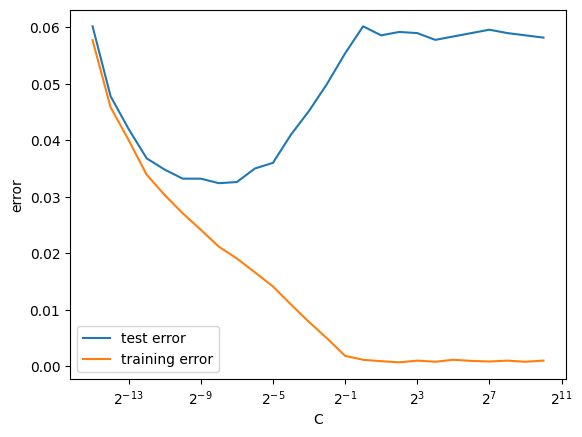

The best value of C using the dual formulation is:0.00390625.
The runtime using the dual formulation was 68.38376760482788 seconds


In [156]:
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
# Select a subset of samples for training and testing
train_samples = 5000
X_train, X_test, y_train, y_test = train_test_split(X_3_8, y_3_8, train_size=train_samples, random_state=42)
# Specify the hyperparameter grid
param_grid = {'C': np.logspace(-15, 10, num=26, base=2)}
# Initialize the Linear Support Vector Classifier (SVC) model
svm = LinearSVC(penalty='l2', loss='hinge', dual=True)
# Initialize the grid search to find the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=False, return_train_score=True)
# Train the model using the grid search and time the process
start_time=time.time()
grid_search.fit(X_train, y_train)
end_time=time.time()

# Plot the results
# Plot the training and testing errors for each hyperparameter
plt.semilogx(param_grid['C'], 1-grid_search.cv_results_['mean_test_score'], label='test error',base=2)
plt.semilogx(param_grid['C'], 1-grid_search.cv_results_['mean_train_score'], label='training error',base=2)
plt.xlabel('C')
plt.ylabel('error')
plt.legend()
plt.show()


# Print the best hyperparameters and corresponding error rates
best_C = grid_search.best_params_['C']
print(f'The best value of C using the dual formulation is:{best_C}.')
print(f'The runtime using the dual formulation was {end_time-start_time} seconds')

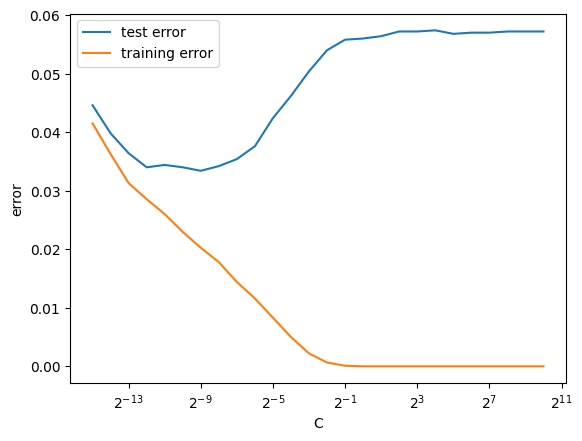

The best value of C using the primal formulation is:0.001953125.
The runtime using the primal formulation was 222.06368327140808 seconds


In [ ]:
# Create a Linear SVM model with primal formulation
svm2 = LinearSVC(dual=False)
# Perform a grid search over hyperparameter C using cross-validation
grid_search2 = GridSearchCV(svm2, param_grid, cv=5, n_jobs=-1, verbose=False, return_train_score=True)
start_time=time.time()
grid_search2.fit(X_train, y_train)
end_time=time.time()

# Plot the results of the grid search
plt.semilogx(param_grid['C'], 1-grid_search2.cv_results_['mean_test_score'], label='test error',base=2)
plt.semilogx(param_grid['C'], 1-grid_search2.cv_results_['mean_train_score'], label='training error',base=2)
plt.xlabel('C')
plt.ylabel('error')
plt.legend()
plt.show()


# Print the best hyperparameters and corresponding error rates
best_C2 = grid_search2.best_params_['C']
print(f'The best value of C using the primal formulation is:{best_C2}.')
print(f'The runtime using the primal formulation was {end_time-start_time} seconds')

We found that the training time of the dual formulation was 3.64 times faster than its primal counterpart, confirming the theoretical expectation that the dual formulation yields faster results when there are many more dataset values than features.

As observed in the previous graphs, both have similar behaviour, as well as the best values of $C$ in each case, i.e, they have the same "magnitude". We can see that C values within the range of $10^{-4}$ and $10^{-1}$ yield superior performance by getting lower values of the test error. Values beyond this range tend to result in overfitting of the model with the training data. We found that the optimal value of the regularization parameter, C, using GridSearchCV is 0.00390625 in the dual case. This value indicates that we allow bigger values for the slack variables (in the SVM formulation), which can lead to more misclassifications but also results in a more flexible model that can classify better. 

Alternatively, a lower value of C implies a higher strength of regularization, in this case, 256. This means that we are penalizing bigger values of the weights in the hyperplane used to classify our data. As a result, we will get smaller values for the weights, which makes the margin of the classification hyperplanes larger. This, in turn, allows more misclassifications in order to a better classification performance in all the dataset.



### (d) Weights 
Extract the weights of the classification model found in (b).

In [157]:
# Extracting the learned weights and bias term of the best estimator found by GridSearchCV
w = grid_search.best_estimator_.coef_
print( f'There are {w.size} values in the weight, that should be the same as the number of features.' )
w0 = grid_search.best_estimator_.intercept_
grid_search.best_estimator_

There are 784 values in the weight, that should be the same as the number of features.


LinearSVC(C=0.00390625, loss='hinge')


### (e)  Plots and results
Plot the discriminant function weights as follows:

i. Arrange the weights in a matrix with the same shape as the input image.

ii. Use a function such as pcolor https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolor_demo.html to produce a color plot of the matrix.

iii. Use a diverging colormap that emphasizes negative and positive values http://matplotlib.org/examples/color/colormaps_reference.html.

iv. Discuss the results.


The MNIST dataset consist of $28\times 28$ px images, so let's check by plotting the first value of our test dataset.

513
This sample should be 3


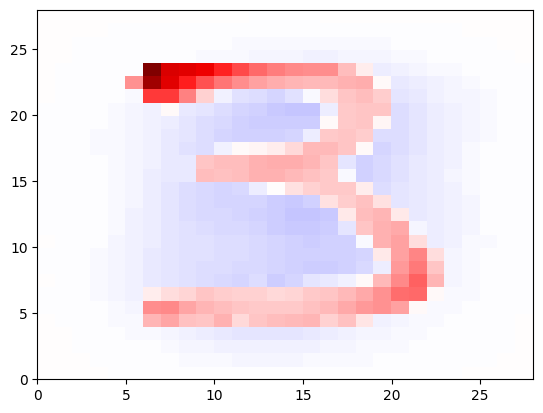

In [162]:
number=np.random.randint(low=0, high=y_test.size)
print(number)
print(f'This sample should be {y_test[number]}')
v_max=np.max(np.abs(X_test[number]))
plt.pcolor(np.flipud(X_test[number].reshape(28,28)),cmap='seismic', vmax=v_max, vmin=-v_max);

How the weights look like if we plot it in the same way?

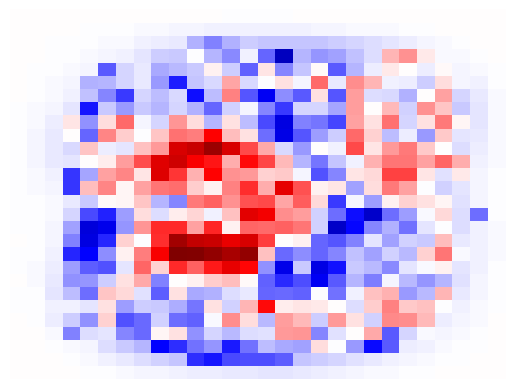

In [163]:
fig, ax = plt.subplots()
v_max=np.max(np.abs(w))
pc = plt.pcolor(np.flipud(w.reshape(28,28)),cmap='seismic',vmax=v_max, vmin=-v_max);

# Hide the axis
ax.axis('off')

plt.show()


we observed that the weights in our model can take on both positive and negative values, and we applied the pcolor function with specific settings to display the distribution of these values. However, we were unsure of the meaning behind the colors that were generated by the function. After careful consideration, we hypothesized that each color may correspond to a different digit. This is because the weights are a fundamental part of the discrimination function. Specifically, in the image we generated, the red color could represent the digit '3', while the blue color could represent the digit '8'.

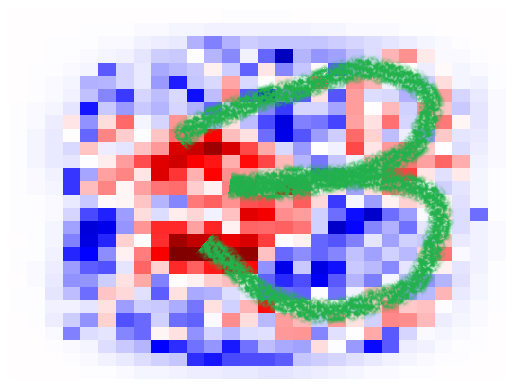

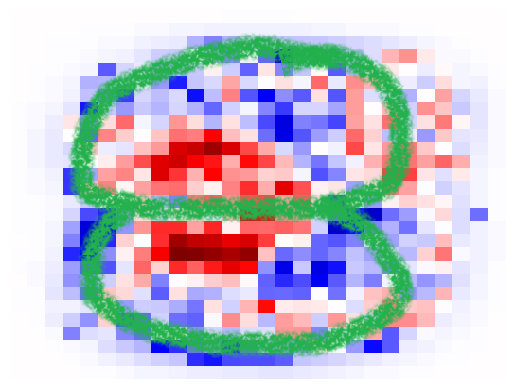

Also we observed that the weights in our model tended to be heavier in areas where the ends of the digit '3' are typically located. This suggests that these areas contain features that are particularly useful for distinguishing between the digits '3' and '8'. It is worth noting that the areas with the most intense red coloration are also situated in regions where the loops of the digit '8' are closed. This feature is crucial for distinguishing the '8' from the '3', which does not have any closed loops. Additionally, we noticed that the rounded parts of the digits, which are similar in shape between the '3' and '8', were less important in the classification task. This is reflected in the mixture of colors observed in these areas.

### (f) Experimenting with pairs of digits
Play with different pairs of digits and with different values for the C parameter (smaller
values could produce smoother plots). Discuss the results.

We asked to ChatGPT to mention pairs of digits that could be interesting to compare:
* 0 and 6: Both digits have a circular shape, but the 6 has a tail at the top.

* 4 and 9: Both digits have a similar shape with a loop at the top, but the 9 has a longer tail at the bottom, and 4 loop looks like a triangle, while the 9 loop is more like a circle.

* 5 and 6: 5 has no loops, but 6 does not. However, you can convert a 6 into a 5 by removing the loop.

* 3 and 9: Both digits have a similar shape but the 9 has a tail at the bottom and the 7 does not.

We will also consider other pairs

Let's see if we can see this differences from the weights images obtained after training an SVM. We will consider the following values for C: $2^{-12}, 2^{-10}, 2^{-8}, 2^{-6},2^{-4}, 2^{-2}, 2^{-1}$ and $1$.



In [ ]:
def experiment_with_digits(d1,d2):
  """
    This function performs an experiment with two specified digits from the MNIST dataset. 
    It trains a Linear Support Vector Classifier on a subset of the dataset and plots the learned weights for 
    different values of C.
    
    Parameters:
    d1 (int): The first digit to select
    d2 (int): The second digit to select
    
    Returns:
    None
  """
  train_samples = 5000
  # Select the specified digits
  X_d1_d2, y_d1_d2=select_classes(str(d1),str(d2)) 
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_d1_d2, y_d1_d2, train_size=train_samples, random_state=42)
  # Define a dictionary that maps the exponent of C to the corresponding subplot position
  
  loop_dict={-15:[0,0],
             -14:[0,1],
             -13:[0,2],
             -12:[1,0],
             -11:[1,1],
             -10:[1,2],
             -9:[2,0],
             -8:[2,1],
             -2:[2,2]}
  # Create a subplot for each value of C and plot the learned weights
  fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
  fig.suptitle("Experiment with the digits "+str(d1)+" and "+str(d2))
  for exponent,position in loop_dict.items():
    svm = LinearSVC(penalty='l2', loss='hinge', dual=True, C=2**exponent)
    svm.fit(X_train,y_train)
    w=svm.coef_
    max_val=np.max(np.abs(w))
    axs[position[0],position[1]].pcolor(np.flipud(w.reshape(28,28)),cmap='seismic',vmin=-max_val,vmax=max_val)
    axs[position[0],position[1]].axis('off')
    subtitle='$C=2^{'+str(exponent)+'}$'
    axs[position[0],position[1]].set_title(subtitle)
  plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


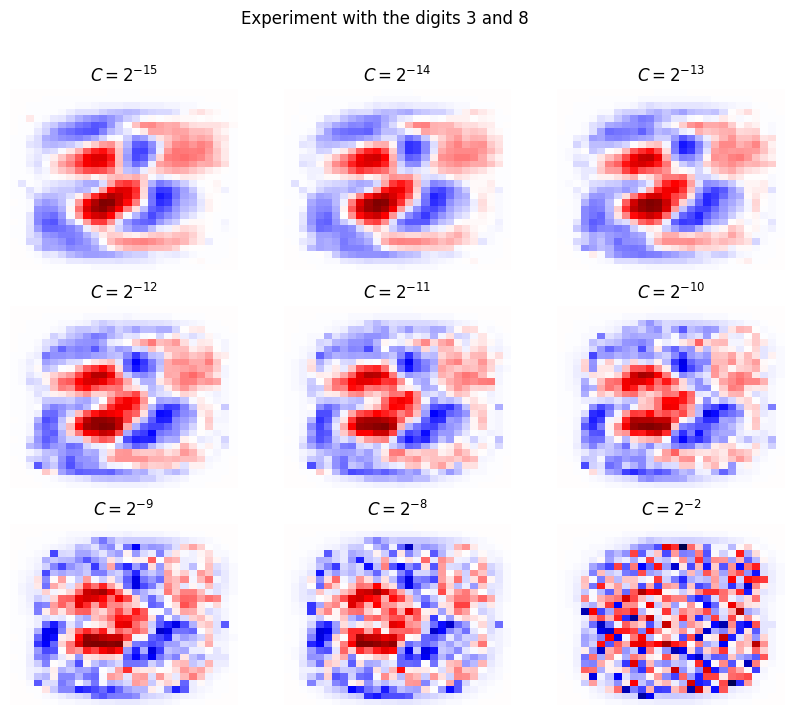

In [ ]:
experiment_with_digits(3,8)

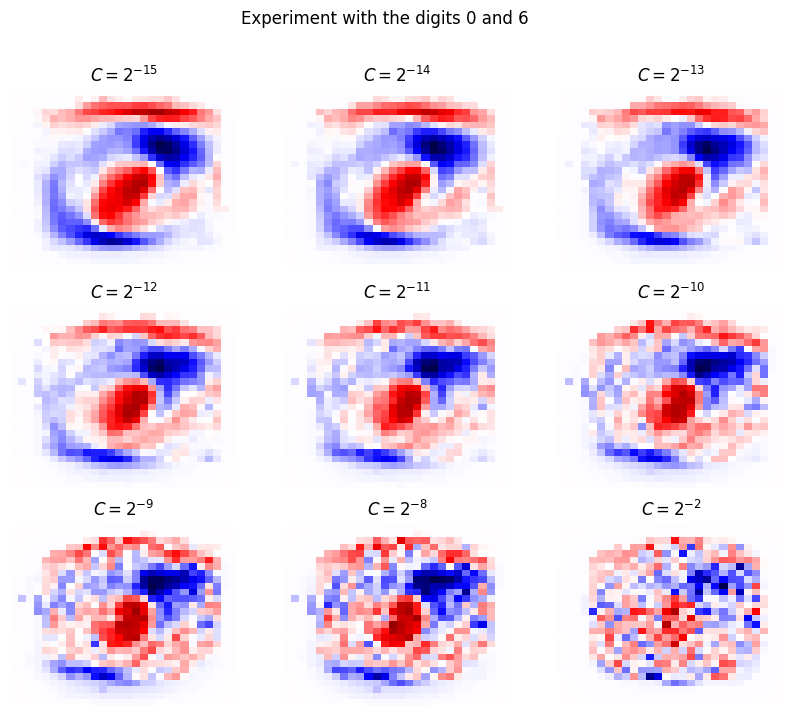

In [ ]:
experiment_with_digits(0,6)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


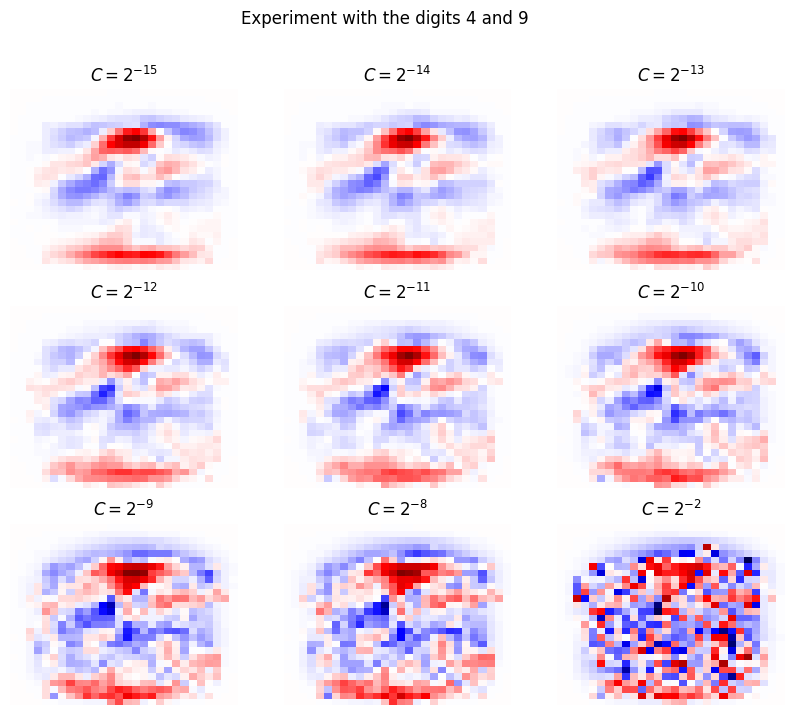

In [ ]:
experiment_with_digits(4,9)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


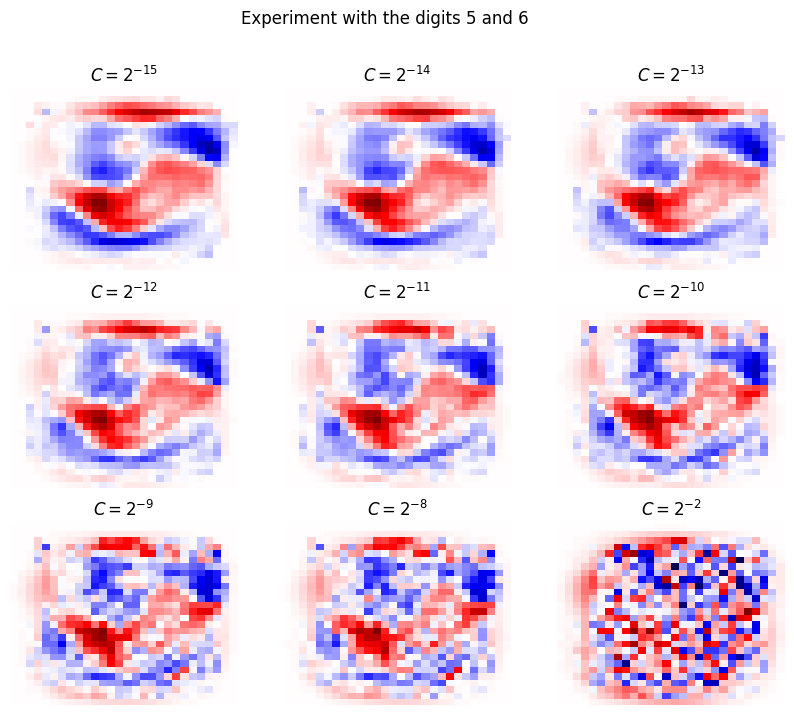

In [ ]:
experiment_with_digits(5,6)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


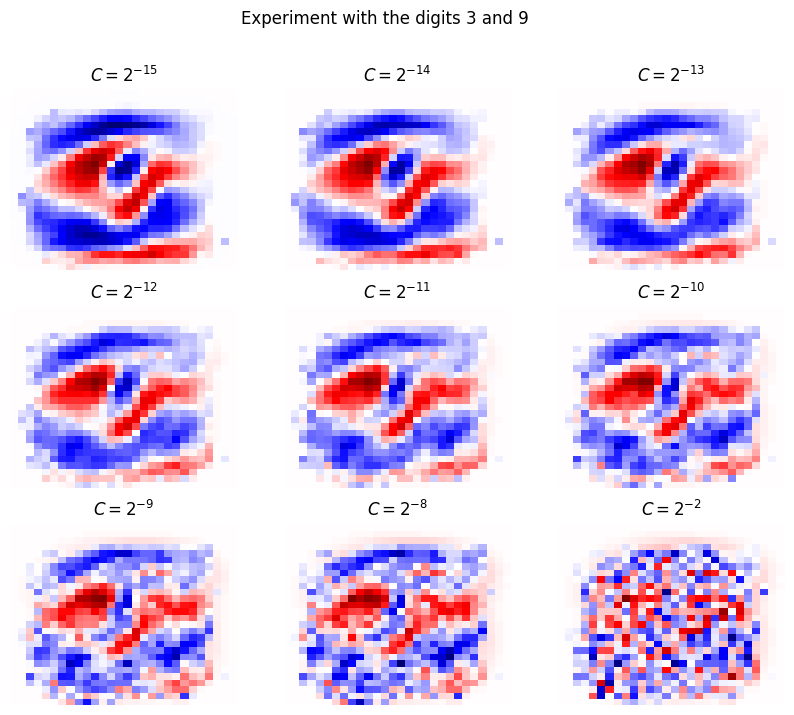

In [ ]:
experiment_with_digits(3,9)

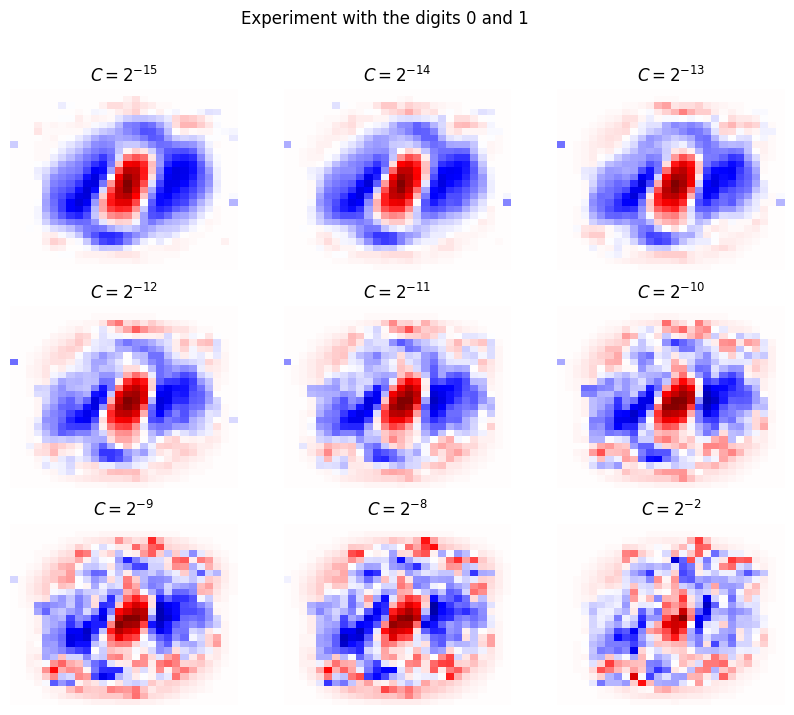

In [ ]:
experiment_with_digits(0,1)

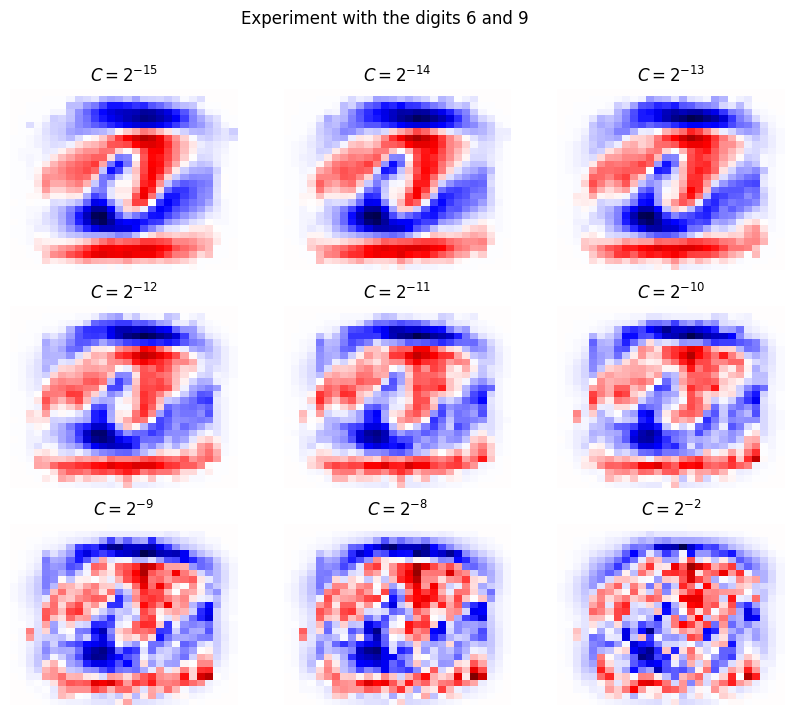

In [ ]:
experiment_with_digits(6,9)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


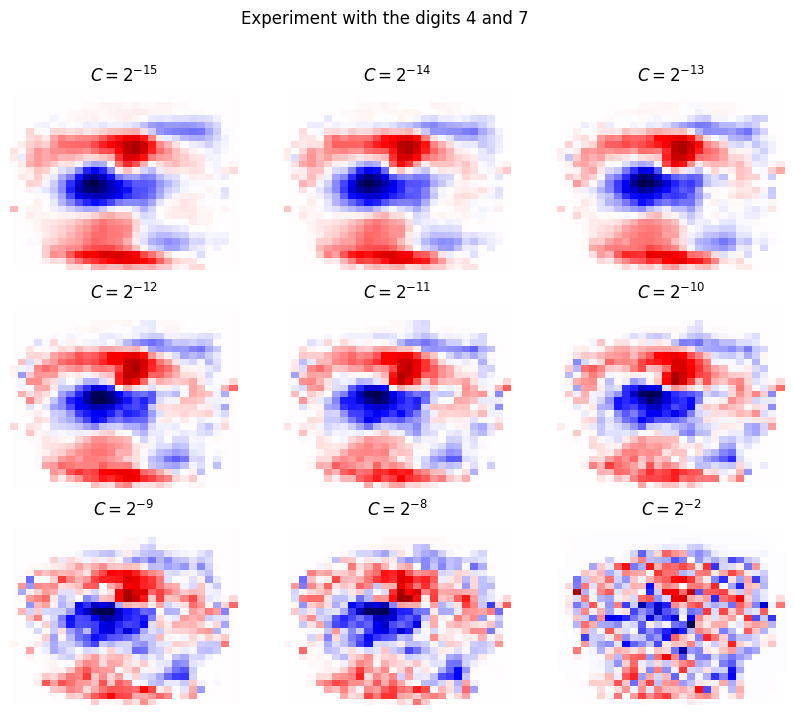

In [ ]:
experiment_with_digits(4,7)

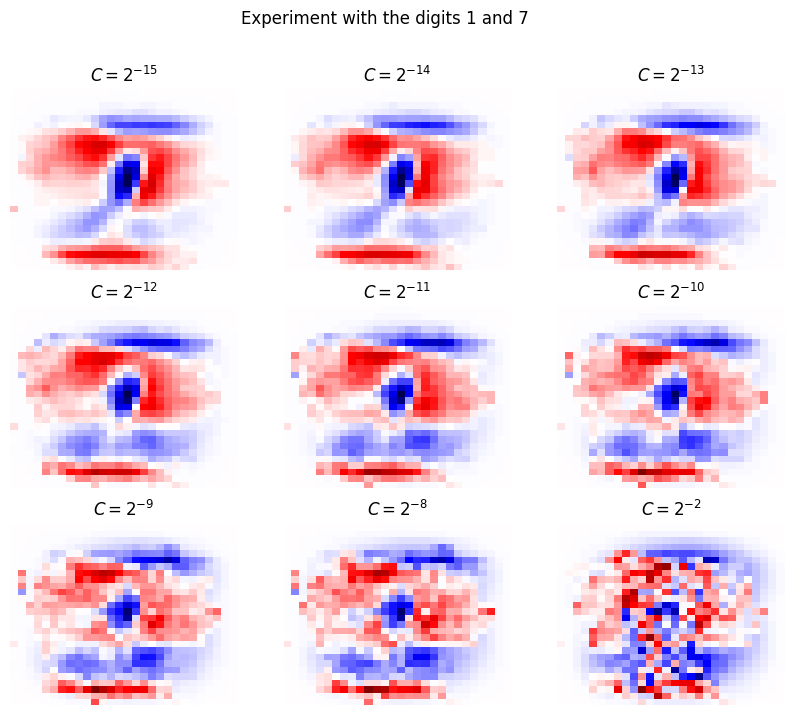

In [ ]:
experiment_with_digits(1,7)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


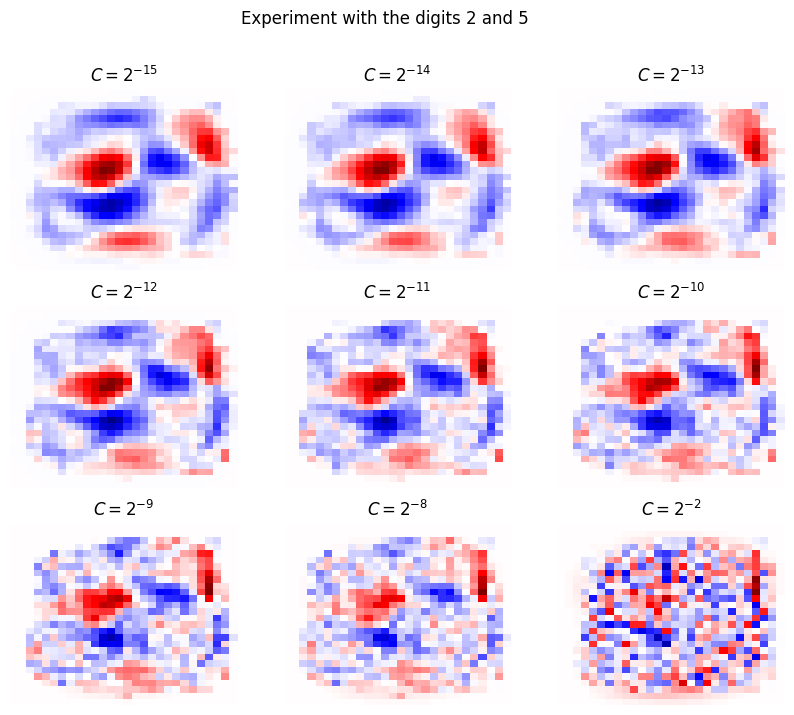

In [ ]:
experiment_with_digits(2,5)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


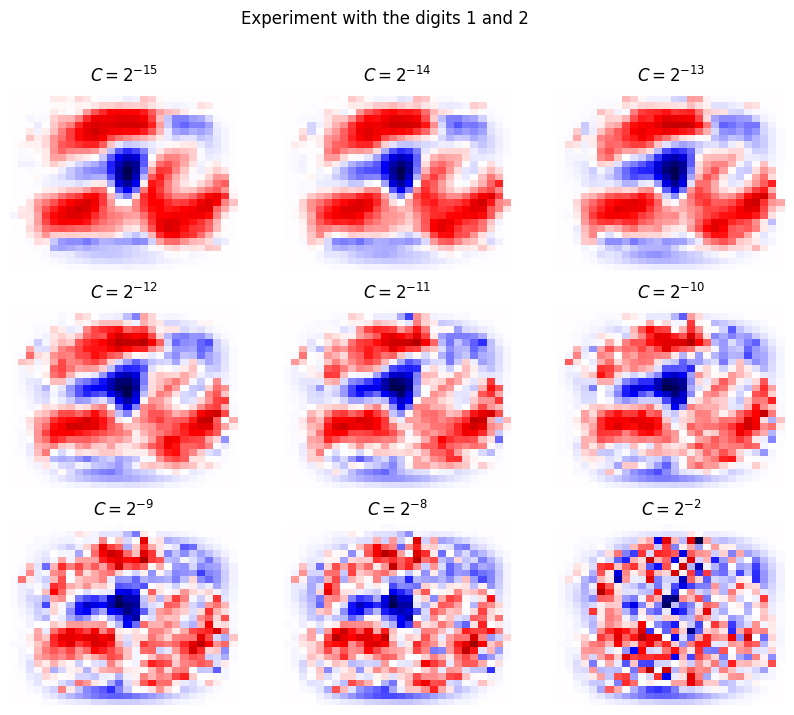

In [ ]:
experiment_with_digits(1,2)

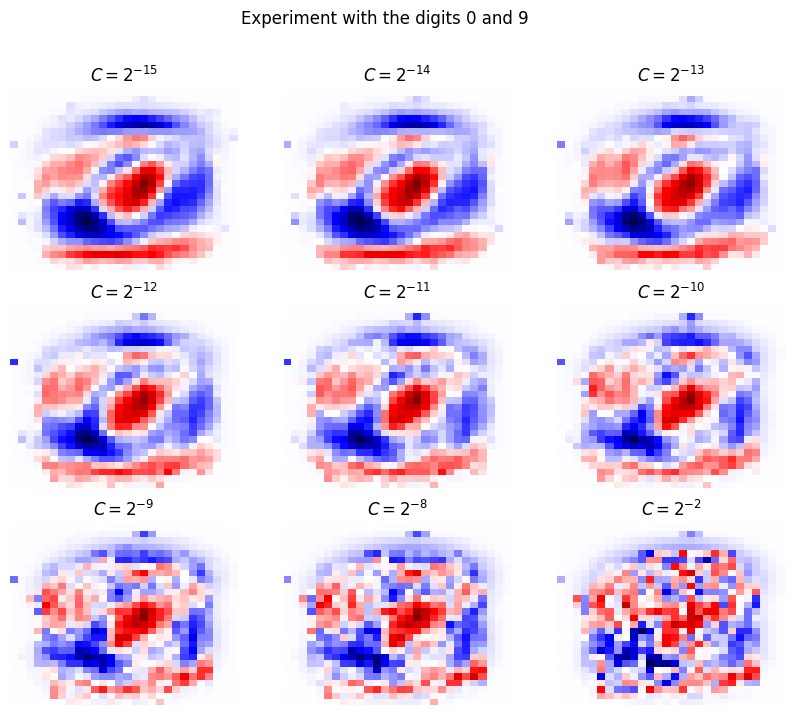

In [ ]:
experiment_with_digits(0,9)

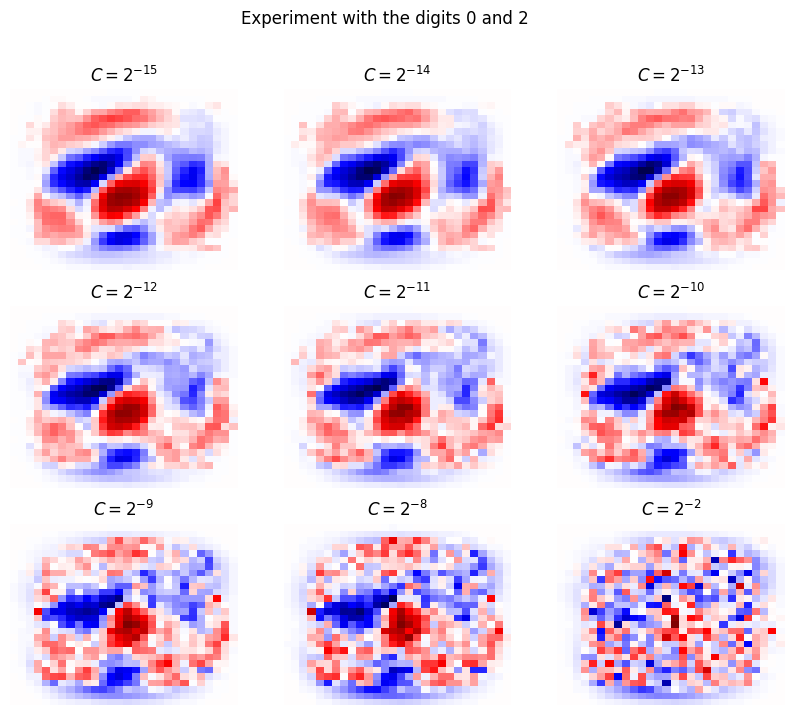

In [ ]:
experiment_with_digits(0,2)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


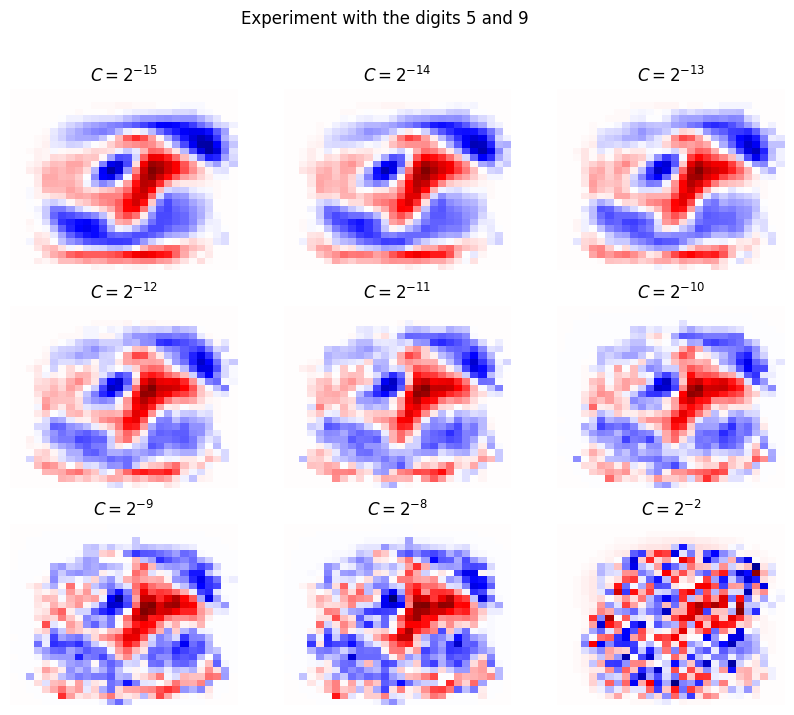

In [ ]:
experiment_with_digits(5,9)

Based on the results, it can be inferred that lower values of C result in smoother plots and, in most cases, make it possible to differentiate between the digits. Digits with loops such as (0,6),(0,9), (6,9), (3,9),(5,6), and (0,1) are easier to distinguish, whereas digits without loops such as (1,2),(4,7), and (1,7) are harder to differentiate. The case of digit 2 is particularly interesting because some people add a loop, which can make it difficult to distinguish between the plots.
Other case would be interpret that each color distinguish one digit. In the case of 2 and 5, we could observe the following:

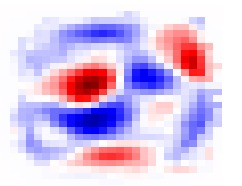

And the following could be the possible interpretation of the colors: 2-blue and 5-red

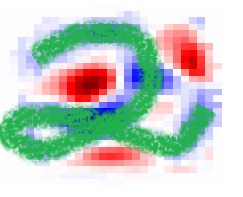

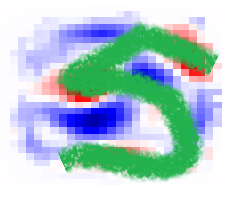

The same happens for the digits 3 and 9, as it is shown below:

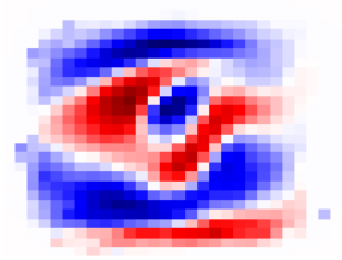

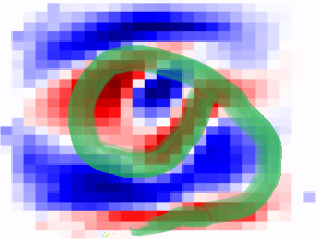

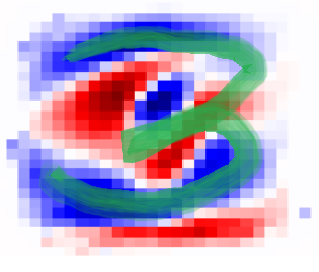

Based on our analysis of numerous pairs of digits, we have reached the conclusion that the assumption that negative weights represent one digit and positive weights represent the other is highly plausible. Additionally, we have observed several recurring patterns within individual digits. For instance, in images featuring the digit '6', there is often a representation of the upper line of the digit located in the upper region of the image. Similarly, we have observed that the digit '9' tends to feature a representation of its lower line in the lower region of the image.

It is crucial to emphasize that the weight images generated by our analysis contain patterns that are highly effective at differentiating between the two digits being compared. For example, in the case of the digit '2', the typical curved end located in the lower region of the image consistently emerges as a significant feature that distinguishes this digit from others. In instances where digits consist of predominantly straight lines, such as the digits '1', '4', and '7', the weight images will tend to highlight the edges of these digits.




---



---



## 3. Kernel logistic regression

We will implement a kernel version of logistic regression. The goal is to train a logistic regression model on a feature space F. Specifically, the discriminant function of the model is given by:
$f(x) = P(C = 1|x) = \sigma(w\Phi(x))$,
where $\Phi : X → F$ is a mapping function associated with a kernel function $k : X \times X → R$ and σ is the logistic function. Assume that the weight vector $w$ is expressed as a linear combination of the training samples:
$$w = \sum_{i=1}^n \alpha_i \Phi(x_i)$$

(a) Write a expression of the discriminant function expressed in terms of the kernel and the
coefficients $\alpha_i$.

As our discriminant function is defined by $f(x)=\sigma(w\Phi(x))$, we could rewrite it in terms of $\alpha_i$ as follows:
$$f(x)= \sigma\left( \sum_{i=1}^n \alpha_i \Phi(x_i)^T \Phi(x)\right),$$
$$f(x)= \sigma\left( \sum_{i=1}^n \alpha_i \Phi(x_i)^T \Phi(x)\right),$$
$$f(x)= \sigma\left( \sum_{i=1}^n \alpha_i k(x_i,x)\right),$$
where $k(\cdot,\cdot)$ is the kernel function.

(b) Formulate the problem of learning the parameters of the model as an optimization problem that looks for the parameters $\alpha_i$ that minimize a cross entropy loss function.

For logistic regression, the most natural approach is to minimize a cross entropy loss function. A possible explanation of this comes from modelling the problem from a probabilistic view, and assume the data follows a Bernoulli distribution. We would like to find the optimum values of $\alpha_i$, so we will formulate the problem as maximizing the log-likelihood function or equivalently, minimizing the negative of the log-likelihood function:
$$ -\log \mathcal{L(\alpha)} = -\sum_{i=1}^n \log \hat{\mathcal{P}}(y^{(i)}|\Phi(x^{(i)});\alpha_i),$$
So, we get
$$ -\log \mathcal{L(\alpha)} = -\sum_{i=1}^n \log \hat{\mathcal{P}}(y^{(i)}|\Phi(x^{(i)});\alpha_i).$$
For a particular data sample, we know how to compute $\hat{\mathcal{P}}(C=1|\Phi(x^{(i)});\alpha_i)= f(x^{(i)},\alpha)$, as above, and since it is a binary classification problem, we could compute $\hat{\mathcal{P}}(C=0|\Phi(x^{(i)});\alpha_i) = 1-\hat{\mathcal{P}}(C=1|\Phi(x^{(i)});\alpha_i)$. However, in the expression above, we do not know what $y^{(i)}$ is, so in order to get a general expression, we could express $\hat{\mathcal{P}}(C=y^{(i)}|\Phi(x^{(i)});\alpha_i)$ as:
$$\hat{\mathcal{P}}(C=y^{(i)}|\Phi(x^{(i)});\alpha_i)= \hat{\mathcal{P}}(C=1|\Phi(x^{(i)});\alpha_i)^{y^{(i)}} \times  \hat{\mathcal{P}}(C=0|\Phi(x^{(i)});\alpha_i)^{1-y^{(i)}}.$$
So, if $y^{(i)}=1$, we get the first factor, and if $y^{(i)}=0$, we get the second one as desired.
Applying this on to the log-likelihood expression we get,
$$-\log \mathcal{L}(\alpha) = - \sum_{i=1}^n \left( y^{(i)}\log \hat{\mathcal{P}}(C=1|\Phi(x^{(i)});\alpha_i) + (1-y^{(i)}) \log \left( 1-\hat{\mathcal{P}}(C=1|\Phi(x^{(i)});\alpha_i)\right)\right),$$
$$-\log \mathcal{L}(\alpha) = - \sum_{i=1}^n \left( y^{(i)}\log f(x^{(i)},\alpha) + (1-y^{(i)}) \log (1-f(x^{(i)},\alpha)) \right) = \text{CE}(\alpha).$$
This is, the expression of the cross entropy. So we can find our optimal $\alpha_i$ values by minimizing the cross entropy loss function:
$\arg \min_\alpha \text{CE}(\alpha)$.

(c) Write a function that receives a training data set and a kernel function and finds a vector $\alpha$ that minimizes the loss function using gradient descent.

It is well know that the Cross Entropy Loss Function is a convex problem, in particular, it can be optimized using the gradient descent algorithm.
Before start to code, let's write the CE loss function in a vectorial form:
$$\text{CE}(\alpha) = - y^T \log(\sigma(K \alpha)) - (1-y)^T \log(1-\sigma(K \alpha)),$$
where $K$ is a kernel matrix associated to the dataset.
So $$\nabla_\alpha \text{CE}(\alpha)= K (\sigma(K\alpha) - y).$$
The gradient descent algorithm consist of iteratively update the variable, and can be expressed as follows:
$$\alpha^{(i+1)} = \alpha^{(i)} - \lambda \nabla_\alpha \text{CE}(\alpha^{(i)}),$$
where $\lambda$ is the learning rate.
Replacing the gradient we get
$$\alpha^{(i+1)} = \alpha^{(i)} - \dfrac{2}{||K||_F} K(\sigma(K\alpha^{(i)}) - y),$$
where $\lambda = \dfrac{2}{||K||_F}$ and $||\cdot||_F$ is the Frobenius norm. [See https://towardsdatascience.com/binary-cross-entropy-and-logistic-regression-bf7098e75559, or https://arxiv.org/abs/1902.07399]


In [ ]:
# Import standard Python libraries.
import numpy as np

# Import sklearn utility functions.
from sklearn.base import BaseEstimator, ClassifierMixin

# Import the default kernel
from sklearn.metrics.pairwise import linear_kernel

# Sigmoid function defined using the log-add-exp trick
def sigmoid_function(x):
  return np.where(x < 0, np.exp(x - np.logaddexp(0, x)), np.exp(-np.logaddexp(0, -x)))

class KernelLogisticRegression(BaseEstimator, ClassifierMixin):

  """
  Implementation of Kernel Logistic Regression. Minimization is performed
  by gradient descent.
  """

  def __init__(self, maxiter=1000, tol=1e-6, kernel=linear_kernel):

    # Maximum number of iterations.
    self.maxiter = maxiter

    # Tolerance for the optimizer.
    self.tol = tol

    # Kernel function
    self.kernel = kernel

  def predict(self, X):
    return (self.predict_proba(X)>0.5).astype(int)

  def predict_proba(self, X):
    # Build the kernel matrix, X here is the new input data and self.X is the data that was used during the training
    K= self.kernel(X, self.X_)
    return sigmoid_function(K @ self.alpha)

  def fit(self, X, y):
    """
    Implementation of the gradient descent method with optimal
    learning rate following [1].
    INPUT
    -----
    X : numpy 2D array. Each row corresponds to one training example.
      It is assumed that the first column is a column of ones (bias).
    y : numpy 1D array. Label (0 or 1) of each example.
    OUTPUT
    ------
    self : The trained logistic regression model.
    References
    ----------
    [1] R. Yedida & S. Saha. LipschitzLR: Using theoritically computed
    adaptive learning rates for fast convergence. arXiv eprint 1902.07399.

    [2] Jean-Christophe B. Loiseau: Binary cross-entropy and logistic regression  
    https://towardsdatascience.com/binary-cross-entropy-and-logistic-regression-bf7098e75559
    """
    # Save a copy of the input data
    self.X_ = X.copy()
    self.y_ = y.copy()

    # Build the Kernel matrix
    self.K=self.kernel(X)

    # Get the number of samples of X
    n_samples=X.shape[0]

    # Define the alpha parameters as a random array
    self.alpha = np.random.rand(n_samples)

    iter=0
    err=1
    while iter<self.maxiter and err>self.tol:
      # Compute the gradient
      grad = self.K@(sigmoid_function(self.K@self.alpha) - y)
      
      # Set the learning rate. See references [1] and [2]
      lambd = 2/np.linalg.norm(self.K, ord='fro')
      
      # Update the alpha
      self.alpha -= lambd * grad
      
      # Add one to the counter
      iter+=1
      
      # Update the error
      err= np.linalg.norm(grad)**2
      
    self.is_fitted_ = True
    return self
    
  def score(self, X, y):
    y_pred = self.predict(X)
    score = accuracy_score(y, y_pred)
    return score

(d) Test your algorithm using different kernels (linear, polynomial, Gaussian, etc.) on synthetic 2D datasets from sklearn (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). 

Plot the decision regions and discuss the results:

We will use the suggested code for plotting the classifier comparison, but making modifications to our problem.

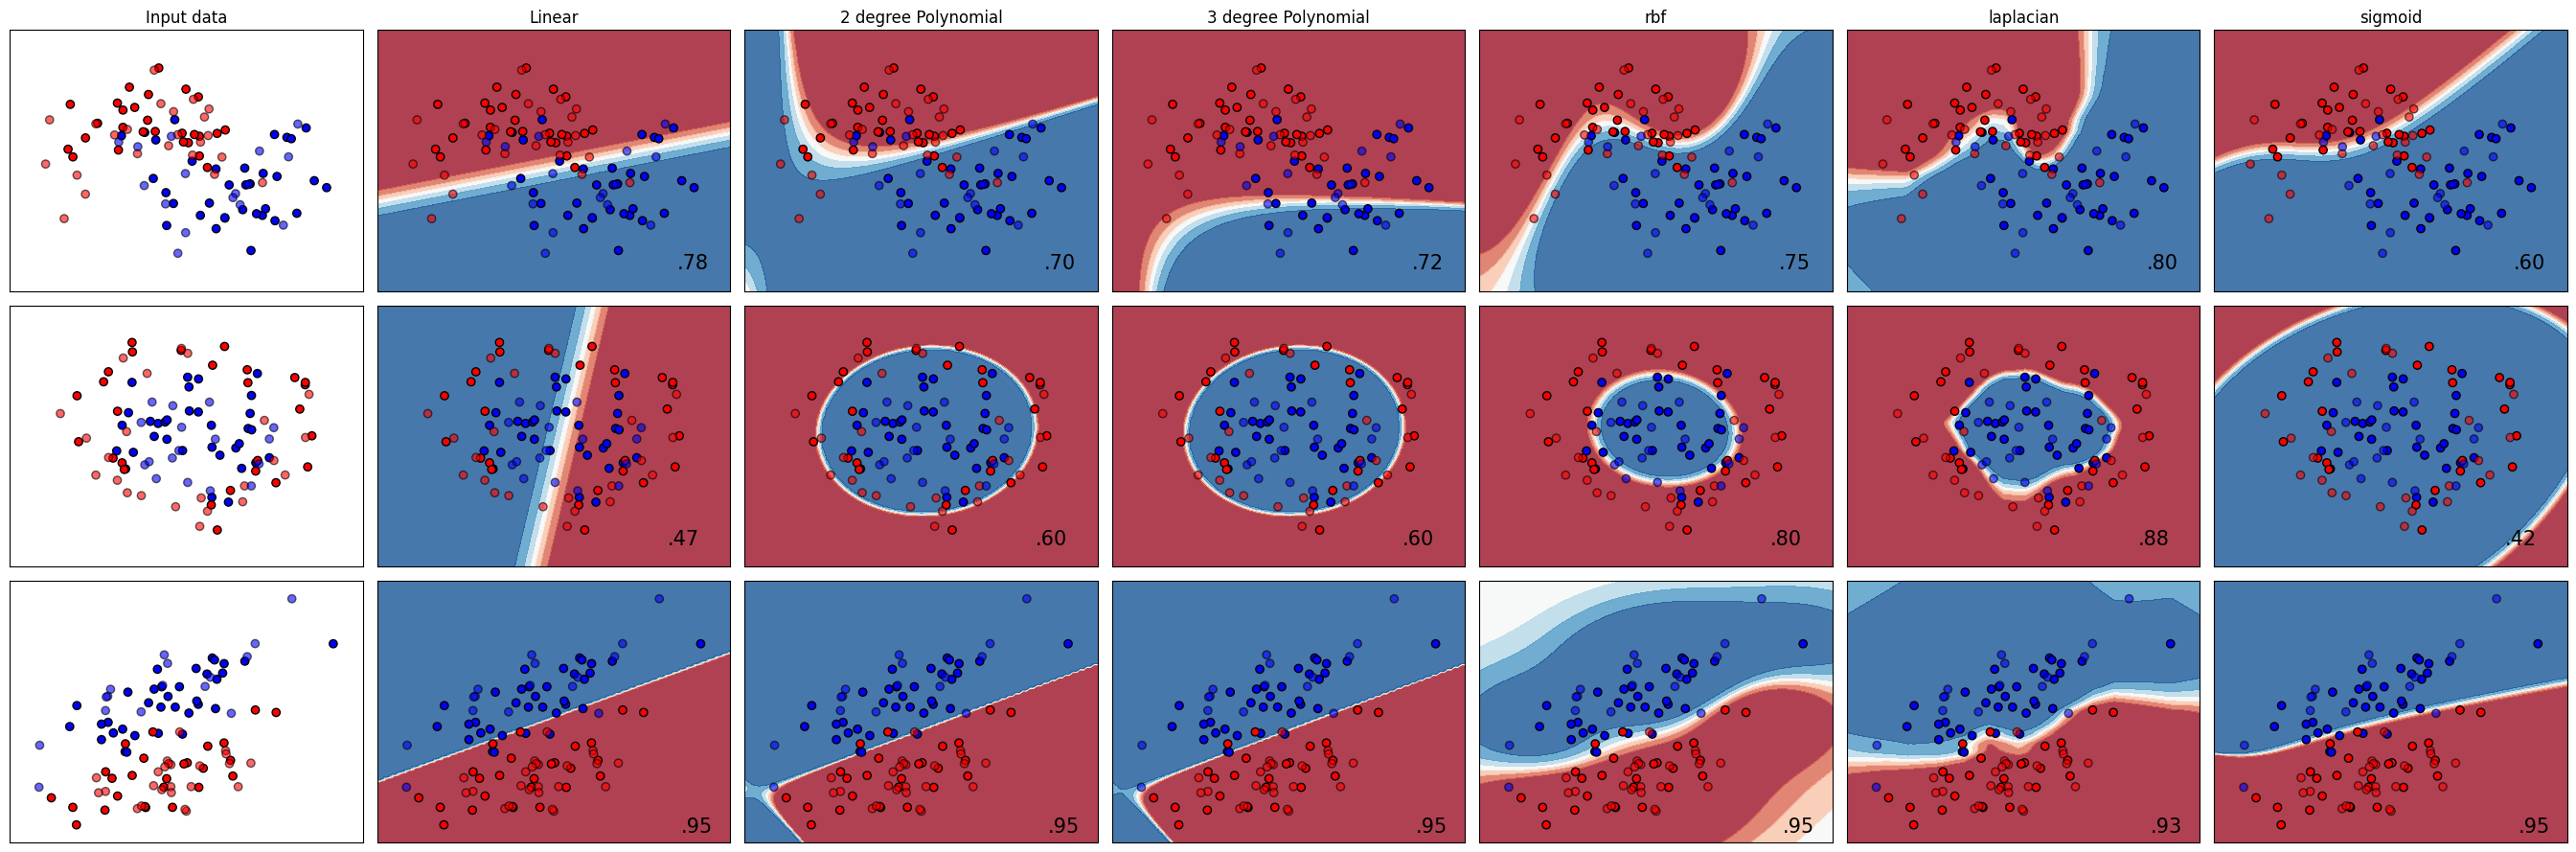

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics.pairwise import chi2_kernel, laplacian_kernel, sigmoid_kernel, rbf_kernel, polynomial_kernel

def quadratic_kernel(X, Y=None):
    return polynomial_kernel(X, Y, degree=2)

def cubic_kernel(X, Y=None):
    return polynomial_kernel(X, Y, degree=2)

names = [
    "Linear",
    "2 degree Polynomial",
    "3 degree Polynomial",
    "rbf",
    "laplacian",
    "sigmoid"
]

classifiers = [
    KernelLogisticRegression(),
    KernelLogisticRegression(kernel=quadratic_kernel),
    KernelLogisticRegression(kernel=cubic_kernel),
    KernelLogisticRegression(kernel=rbf_kernel),
    KernelLogisticRegression(kernel=laplacian_kernel),
    KernelLogisticRegression(kernel=sigmoid_kernel),
]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=42, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=40),
    make_circles(noise=0.2, factor=0.5, random_state=41),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=43
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        #clf.fit(X_train, y_train)
        #clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

Upon analyzing the plots, we have come to the following conclusions:

It is not always the case that every kernel is well-suited for all datasets. In our experiments, we found that the Laplacian kernel produced the most flexible decision boundaries, which resembled non-regular geographical boundaries. The Laplacian kernel performed well on all of the tested datasets. However, we must exercise caution with this kernel to avoid overfitting. The RBF kernel performed well also, and can be considered the second-best kernel based on our experiments.

For the last dataset, we observed that all classifiers performed well, since it was linearly separable. This can be inferred by observing the decision boundaries, which tended to be aligned in a certain direction.

From these observations, it is clear that it is important to test different kernels and choose the most natural one for our specific problem. Furthermore, it is advisable to visualize the decision boundaries produced by different kernels to better understand their behavior.

Additionally, it is worth mentioning that we did not perform hyperparameter tuning for the kernels, such as adjusting the $\gamma$ values for the rbf and Laplacian kernels. Therefore, the results presented may vary, and a more thorough analysis could be conducted by exploring different hyperparameters for each kernel.